In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import StandardScaler, scale, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV, train_test_split, LeaveOneOut, KFold
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import scale
from scipy.stats import ttest_rel
from datetime import datetime

from numpy import logspace, random, isnan
import pickle
from scipy.stats import rankdata
from os.path import basename, join
from os import mkdir 

from json import dumps 
from pickle import dump

import shap
from copy import deepcopy

from sklearn.ensemble import RandomForestRegressor
import TraitData
from imp import reload
import seaborn as sns

## Set Parameters for Analysis 

# Plotting
sns.set()
sns.set(font_scale=1.5)
%matplotlib inline
plt.rcParams['figure.figsize'] = (7,15)
%config InlineBackend.figure_format = 'retina'

# 10-Fold Cross Validator
cv = KFold(n_splits=10)

# Load saved Random State to ensure replicablility.
try:
    SAVED_STATE = pickle.load(open("np.random.state", 'rb'))
    np.random.set_state(SAVED_STATE)
except Exception as e:
    SAVED_STATE = False

<img style="float:right" src="https://www.washington.edu/brand/files/2014/09/W-Logo_Purple_Hex.png" width=60px)/>
<h1> Nonlinear Modeling of Trait-Range Shift Relationships <small> by: Tony Cannistra </small></h1>

We are attempting to understand the type and magnitude of the effects that various physiological or behavioral traits have had on historical range shifts.

The challenge is that standard linear regression has been only able to explain a small percentage of the variance seen in range shift data for several taxa ([Angert et al., 2011](http://onlinelibrary.wiley.com/doi/10.1111/j.1461-0248.2011.01620.x/abstract)). This is likely as a result of the relationships between predictor and response variables being something other than linear, especially since several variables have biological relevance for their ability to facilitate range shifts. 

## Load Data + Define Functions
For this exploration we have trait data for several large taxonomic groups of organisms and their observed range shifts over the past 100 years. There are 3 datasets
### Define Each Dataset

In [2]:
plantsData = {
    'name' : "European Plants",
    'file' : "../data/angert_etal_2011/plants5.csv",
    
    'responseVar'   : "migration_m",

    'drop_features' : ["Taxon",
                     "migr_sterr_m", 
                     "shift + 2SE", 
                     'signif_shift',
                     "signif_shift2",
                     "dispmode01",
                     "DispModeEng", ## what is this
                     "shift + 2SE", 
                      "Grime"],
    'categorical_features' : ["oceanity",
                            "dispersal_mode",
                            "BreedSysCode", "SI01"], 
    
    'traits_desc_file' : "../data/angert_etal_2011/traits-desc-plants.csv"
}

plantsData_extendedDrop = deepcopy(plantsData)
plantsData_extendedDrop['name'] = "Swiss Alpine Plants"
plantsData_extendedDrop.get('drop_features').extend(["Bio1_mean_nosyn",
                                                 "Bio1_std_nosyn",
                                                 "Bio1_var_nosyn", 
                                                 "Bio1_mean_inclsyn",
                                                 "Bio1_std_inclsyn",
                                                 "Bio1_var_inclsyn"])

mammalData = {
    'name' : "Mammals - Full",
    'file' : "../data/angert_etal_2011/mammals01.csv",
    
    'responseVar'   : "High_change",

    'drop_features' : ["Taxon",
                       "High_change_pfa2",
                       "Daily_rhythm_code",
                       "Annual_rhythm_code"],
    
    'categorical_features' : ["Daily01",
                              "Annual01",
                              "Food01",
                              "Daily_rhythm",
                              "Annual_rhythm",
                              "Food"],
    
    'traits_desc_file' : "../data/angert_etal_2011/traits-desc-mammals.csv"
}

mammalData_extendedDrop = deepcopy(mammalData)
mammalData_extendedDrop['name'] = "Mammals"
mammalData_extendedDrop.get("drop_features").extend(["Bio1_mean",
                                                     "Daily01_0",
                                                     "Daily01_1",
                                                     "Annual01_0",
                                                     "Annual01_1",
                                                     "Food01_0",
                                                     "Food01_1"])

triennialMarineData = {
    'name' : "Triennial Marine Survey -- Full",
    'file' : "../data/marine/west-coast-triennial _species_generaltraits.csv",
    'responseVar' : "Latitudinal Difference",
    
    'drop_features' : ["Species", "Latitudinal Std",
                      "FamCode", "GenCode"], 
    
    'categorical_features' : [
        "UsedforAquaculture",
        "Electrogenic",
        "DemersPelag",
        "LTypeMaxM", 
        "Fresh", 
        "Brack", 
        "Saltwater"
    ], 
    
    'traits_desc_file' : "../data/marine/traits-desc.csv"
}

triennialMarineData_extendedDrop = deepcopy(triennialMarineData)
triennialMarineData_extendedDrop['name'] = "Triennial Marine Survey"
triennialMarineData_extendedDrop.get("drop_features").extend(["Electrogenic_Electrosensing only",
                                                              "Electrogenic_electrosensing only",
                                                              "Electrogenic_no special ability",
                                                              "Electrogenic_strongly discharging",
                                                              "Electrogenic_weakly discharging",
                                                              "LTypeMaxM_FL","LTypeMaxM_SL", "LTypeMaxM_TL"])


TRYdata = {
    'name': "European Plants",
    'file': "../data/TRY/rumpf_ShiftsTraitsBuckley_20180418.csv",
    'responseVar' : "LeadingEdge", # there's also "RearEdge" and "Optimum"
    'drop_features' : ['speciesname',
                       'Dispersal',
                       'Persistence', 
                       'RearEdge', 
                       'Optimum'],
    'categorical_features': ['LifeStrategy']
}


datasets = {
    plantsData_extendedDrop['name'] : plantsData_extendedDrop,
    mammalData_extendedDrop['name'] : mammalData_extendedDrop,
    triennialMarineData_extendedDrop['name'] : triennialMarineData_extendedDrop,
    TRYdata['name'] : TRYdata
}
with open("DATA_SPECIFICATION.json", 'w') as dsjson:
    dsjson.write(dumps(list(d for k, d in datasets.items())))
                
all_mses = {}
rankings = []
MSEs = []
COEFs = []
COEFs_all = []

print(", ".join(datasets.keys()))
print("filenames: {}".format(", ".join(d['name'].replace(" ", '-') for k, d in datasets.items())))


Swiss Alpine Plants, European Plants, Mammals, Triennial Marine Survey
filenames: Swiss-Alpine-Plants, European-Plants, Mammals, Triennial-Marine-Survey


---
### Select, Load, and Normalize Dataset

This notebook **needs to be run once per dataset**. Below we select which dataset will be run through the notebook.

In [3]:
dsname = 'Mammals'

In [4]:
# Select Dataset
dataset = datasets[dsname]
dsname = dataset['name'].replace(" ", "-")
runtime = datetime.now().strftime("%Y-%m-%d_%X")

# create results directory 
results_dir = '-'.join([dsname, runtime])
mkdir(results_dir)

# Drop: Rows with any NAs (0), Columns with any NAs (1), or nothing (None)
dropNA  = 0

td = TraitData.TraitData(dataset['file'],
                         dataset['responseVar'],
                         dataset['drop_features'],
                         dataset['categorical_features'],
                         dropNA=dropNA, scale=True)

## rename traits using traits_desc_file, defined above
try: 
    traitnames = pd.read_csv(dataset['traits_desc_file']).fillna('')
    traitnames_map = { a:b for a, b in zip(traitnames.name, traitnames.description)}
    td.feature_names = [traitnames_map[trait] if traitnames_map[trait] != '' else trait for trait in td.feature_names]
    td.X.columns = td.feature_names
except: 
    print("No trait description.")
    
print(len(td.X))
display(td.X.head())
td.X = np.array(td.X)
td.Y = np.array(td.Y)

print(td.X.shape)
print("\n".join(td.feature_names))





28


/home/ec2-user/miniconda3/envs/traits-env/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)
/home/ec2-user/miniconda3/envs/traits-env/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)
/home/ec2-user/miniconda3/envs/traits-env/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)
/home/ec2-user/miniconda3/envs/traits-env/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)
/home/ec2-us

,Altitudinal Limit,Litter Size (individuals),Litters / year,Young / year,Mass (g),Longevity (years),BioClim: Bio 1 (std dev),Range Size (km2),Food_code,Rhythm: Diurnal + Nocturnal (binary),Rhythm: Diurnal (binary),Rhythm: Nocturnal (binary),Facultative Hibernation (binary),No Hibernation (binary),Obligate Hibernation (binary),Granivore (binary) ??,Herivore (binary),Insectivore (binary),Omnivore (binary)
0,-1.780427,-0.509175,0.210725,-0.385922,-0.305936,-0.658218,-1.570086,-0.674237,1,-0.688247,-0.745356,1.452966,-0.408248,0.688247,-0.466252,1,0,0,0
1,-1.659520,-1.527525,0.210725,-0.578884,-0.251574,0.944400,-0.709853,-0.690925,1,-0.688247,-0.745356,1.452966,-0.408248,0.688247,-0.466252,1,0,0,0
2,0.876267,0.509175,-0.969334,-0.578884,5.100035,2.547019,0.711794,-0.089662,2,-0.688247,1.341641,-0.688247,-0.408248,-1.452966,2.144761,0,1,0,0
3,-1.512470,1.527525,2.570843,3.087380,-0.263654,-1.058873,-1.153552,-0.604368,2,1.452966,-0.745356,-0.688247,-0.408248,0.688247,-0.466252,0,1,0,0
4,0.804376,-0.509175,1.390784,0.771845,-0.257614,-1.058873,0.892895,0.750643,2,1.452966,-0.745356,-0.688247,-0.408248,0.688247,-0.466252,0,1,0,0


(28, 19)
Altitudinal Limit
Litter Size (individuals)
Litters / year
Young / year
Mass (g)
Longevity (years)
BioClim: Bio 1 (std dev)
Range Size (km2)
Food_code
Rhythm: Diurnal + Nocturnal (binary)
Rhythm: Diurnal (binary)
Rhythm: Nocturnal (binary)
Facultative Hibernation (binary) 
No Hibernation (binary)
Obligate Hibernation (binary)
Granivore (binary) ??
Herivore (binary)
Insectivore (binary)
Omnivore (binary)


In [5]:
try:
    print(traitnames.description)
except:
    pass

0                        Altitudinal Limit
1                Litter Size (individuals)
2                           Litters / year
3                             Young / year
4                                 Mass (g)
5                        Longevity (years)
6                    BioClim: Bio 1 (mean)
7                 BioClim: Bio 1 (std dev)
8                         Range Size (km2)
9                                         
10                                        
11                                        
12                                        
13                                        
14                                        
15                                        
16    Rhythm: Diurnal + Nocturnal (binary)
17                Rhythm: Diurnal (binary)
18              Rhythm: Nocturnal (binary)
19       Facultative Hibernation (binary) 
20                 No Hibernation (binary)
21           Obligate Hibernation (binary)
22                   Granivore (binary) ??
23         

In [6]:
pickle.dump(np.random.get_state(), open('np.random.state', 'wb'), )


## Learning

In [7]:
## Importance Plotting Function
def plot_importance(importances, names, title=None, std=None, ft="", save=None):
    sns.set()
    sns.set(font_scale=1.5)
    plt.rcParams['figure.figsize'] = (7,15)
    f, ax = plt.subplots()
    
    bar_indices = np.arange(len(names))
    bar_width = 0.45
    importances_ind = np.argsort(abs(importances))

    plt.barh(bar_indices,
             importances[importances_ind],
            align='center', color='#4b2e83', xerr=std)
    
    
    
    plt.figtext(1, 0, ft, ha='right')
    plt.yticks(bar_indices, np.array(names)[importances_ind])
    plt.title(title)
    plt.tight_layout()
    if(save is not None):
        plt.savefig(save, bbox='tight', dpi=200)
    plt.show()
    
def compute_ranks(importances, absolute=True):
    if absolute:
        sorted_idx =  abs(importances).argsort()[::-1]
    else:
        sorted_idx = importances.argsort()[::-1]
    return(np.arange(len(importances))[sorted_idx.argsort()])

def boxplot_importances(coefs, names, title=None, **kwargs):
    sns.set()
    sns.set(font_scale=1.5)
    plt.rcParams['figure.figsize'] = (7,15)
    f, ax = plt.subplots()
    
    coef_medians = np.median(coefs, axis=0)
    coef_medians_sorted = np.argsort(abs(coef_medians))
    
    _ = plt.boxplot(list(np.transpose(np.array(coefs))[coef_medians_sorted]), vert=False, **kwargs)
    plt.yticks(np.arange(len(names)) + 1, np.array(names)[coef_medians_sorted])
        
    ax.axvline(0)
    
    plt.show()
    
    
    

### Linear Models
#### OLS

Err (mean): 8.639831126248964 Err (std.dev): 20.412686705450138


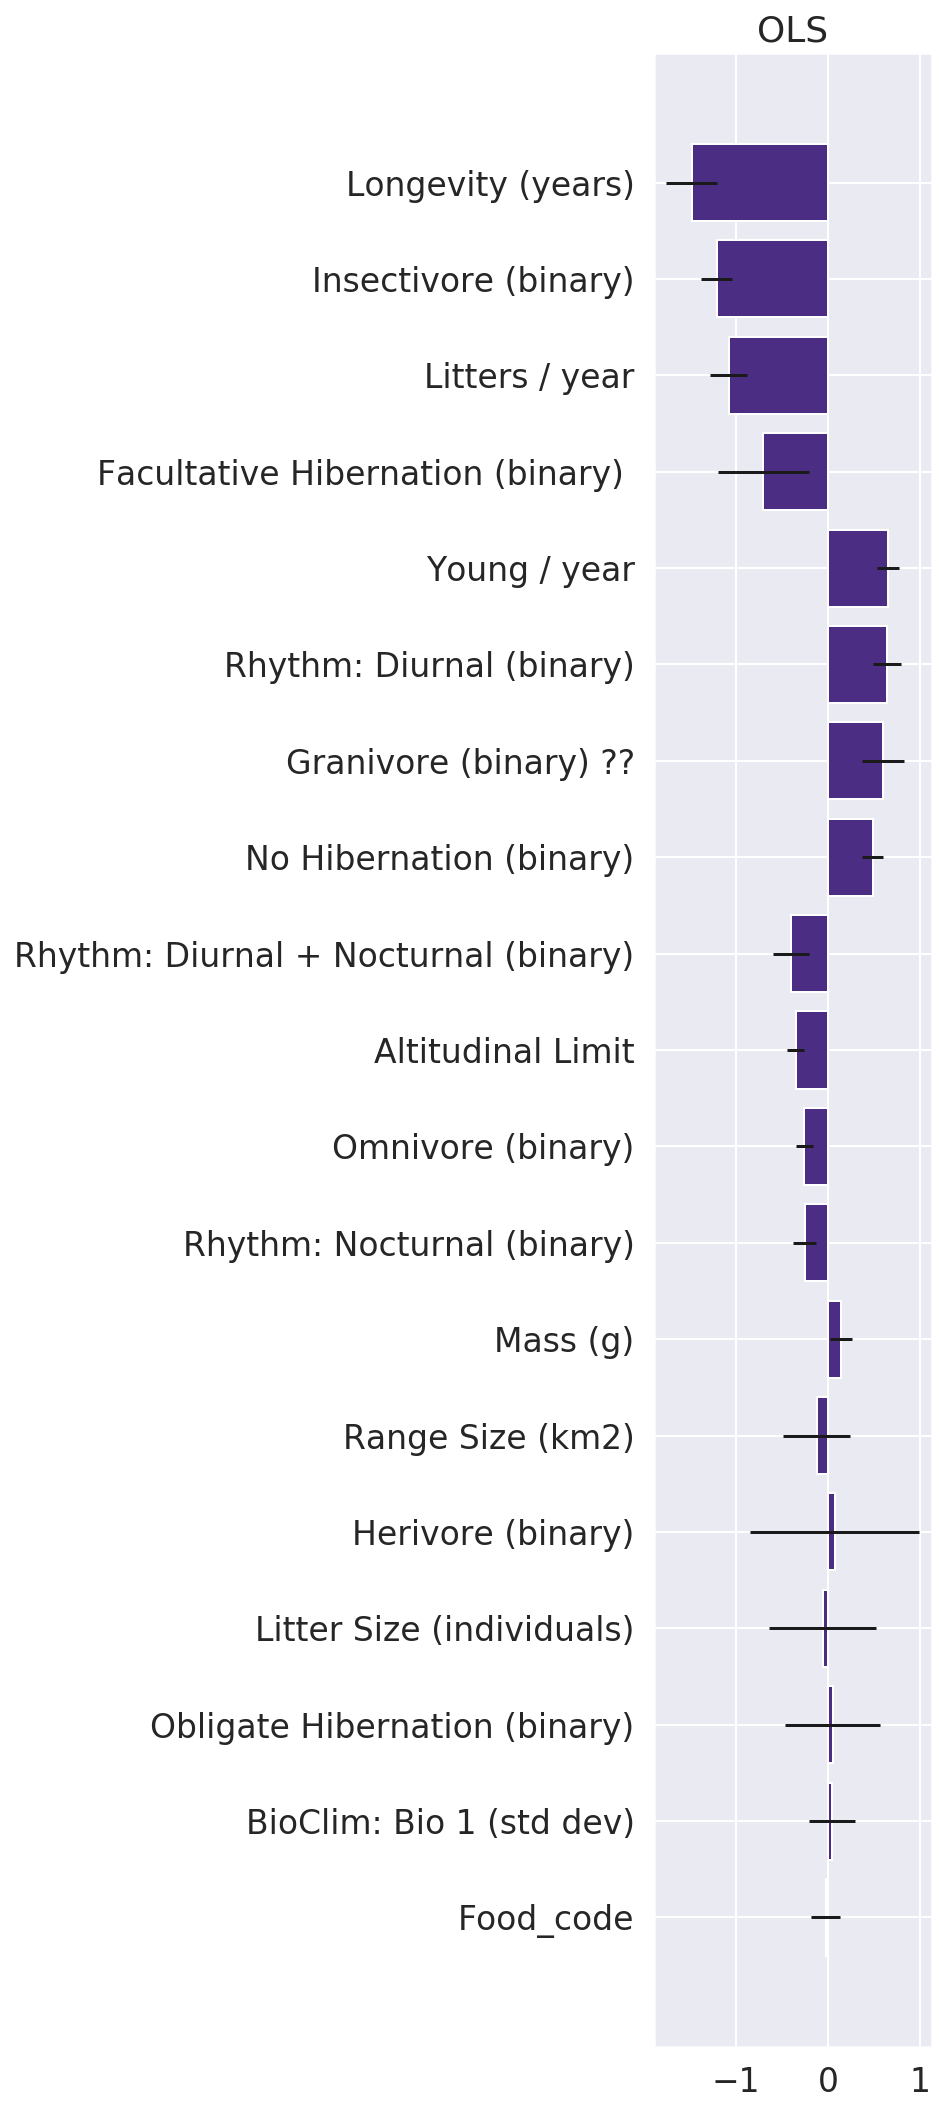

In [8]:
ols_coefs = []
ols_mses = []
for train, test in cv.split(td.X, td.Y):
#     print("#Train: {:d} #Test: {:d}".format(len(train), len(test)))
    ols = LinearRegression(fit_intercept=False, normalize=False)
    ols.fit(td.X[train], td.Y[train])
    preds = ols.predict(td.X[test])
    error = mean_squared_error(td.Y[test], preds)
    ols_mses.append(error)
    ols_coefs.append(ols.coef_)

    
mean_error = np.mean(ols_mses)
std_error = np.std(ols_mses)
mean_coefs = np.mean(ols_coefs, axis=0)
std_coefs = np.std(ols_coefs, axis=0)
print("Err (mean): {} Err (std.dev): {}".format(mean_error, std_error))

plot_importance(mean_coefs,
                td.feature_names, "OLS",
                save="{}_ols-ranks.png".format(join(results_dir, dsname)), std=std_coefs)

MSEs.append(("OLS", ols_mses))
COEFs.append(("OLS", mean_coefs))
COEFs_all.append(("OLS", ols_coefs))
rankings.append(['OLS'] + list(compute_ranks(mean_coefs)))


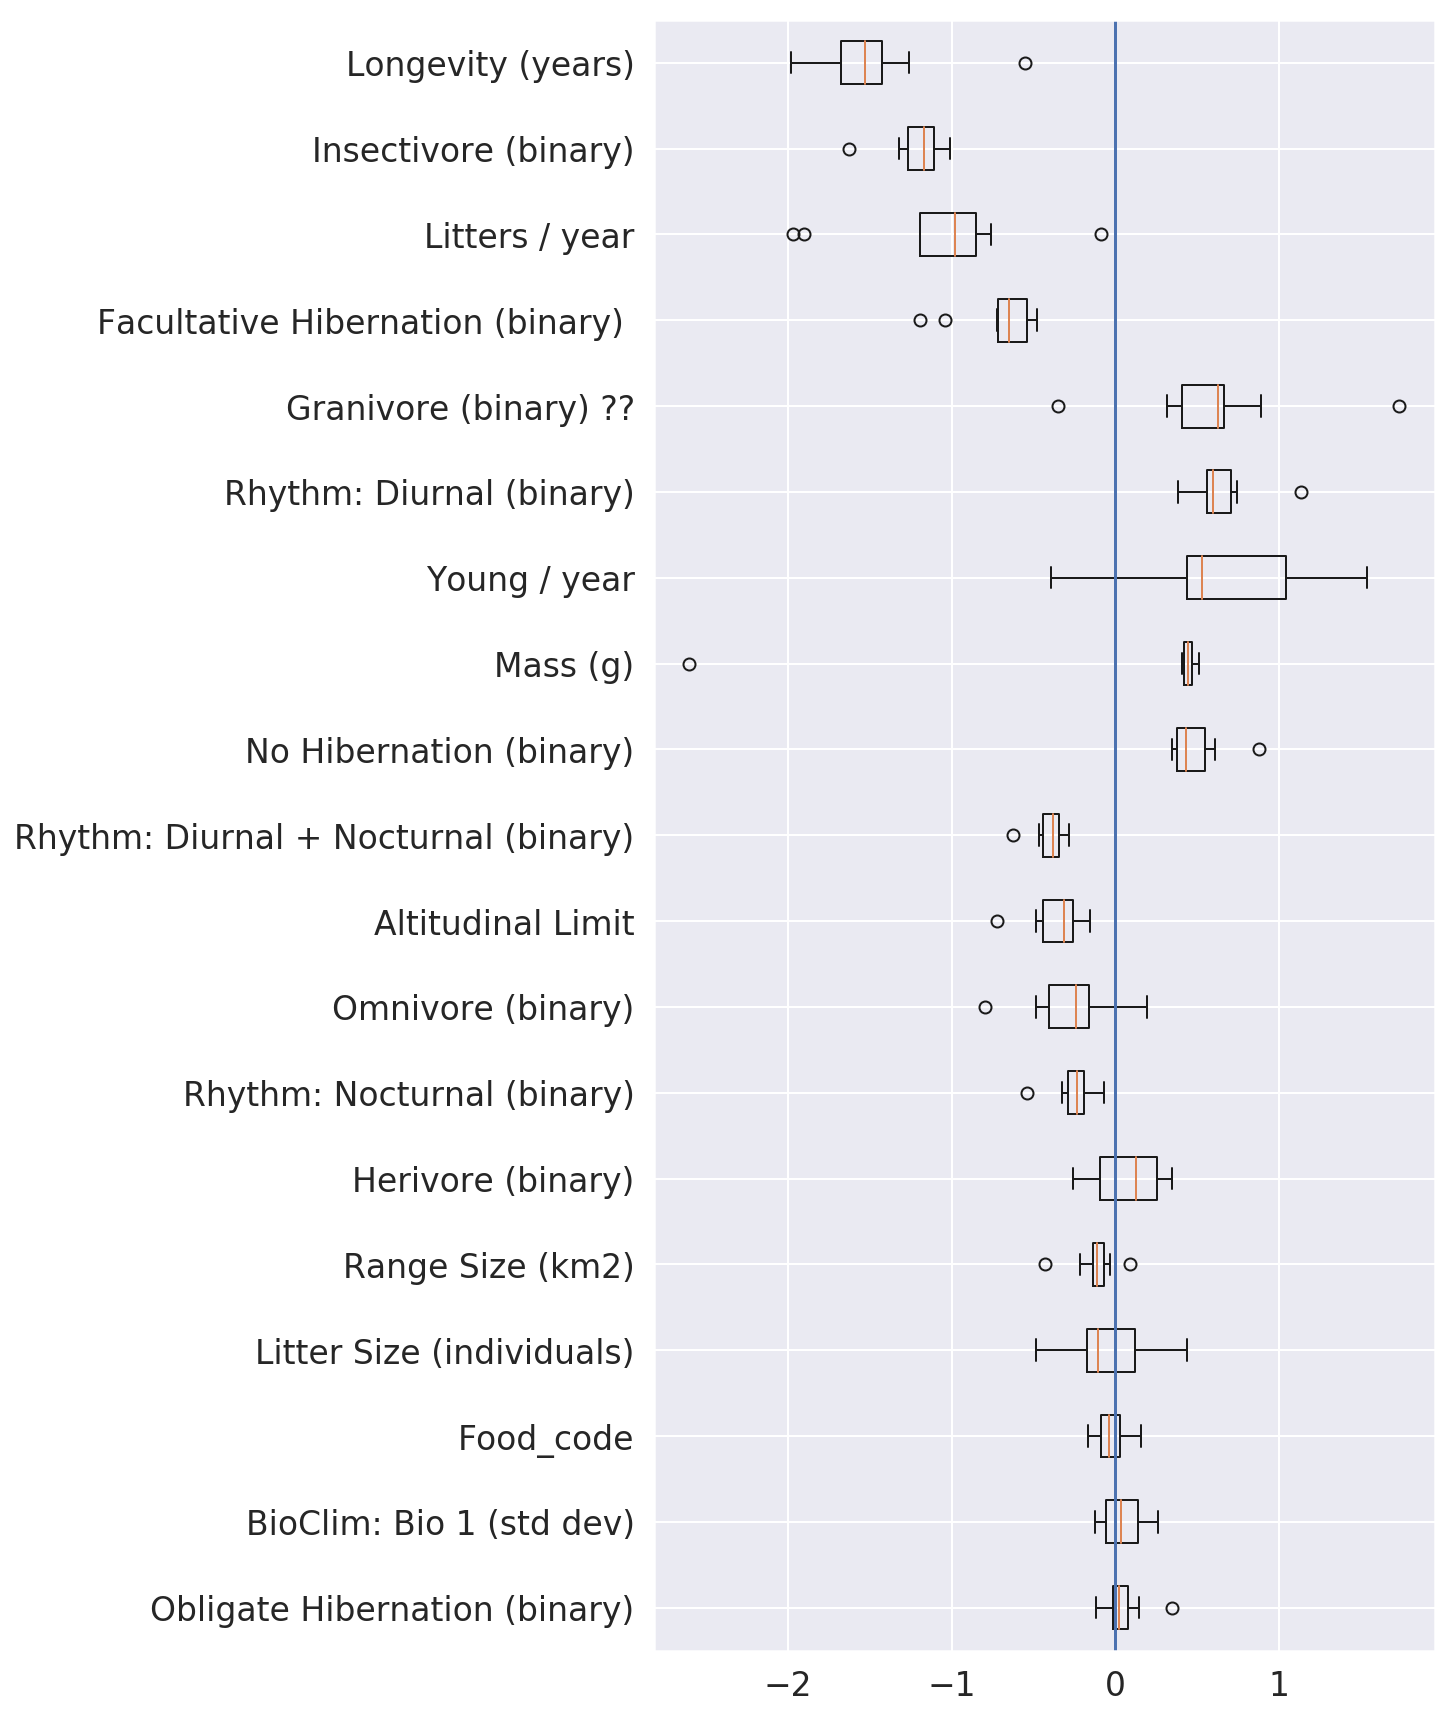

In [9]:
boxplot_importances(ols_coefs, td.feature_names)

#### OLS + Polyfeatures
We're not running this right now.


In [10]:
##
# from sklearn.pipeline import make_pipeline
# ols_coefs = []
# ols_mses = []
# for train, test in cv.split(td.X, td.Y):
# #     print("#Train: {:d} #Test: {:d}".format(len(train), len(test)))
#     ols = make_pipeline(PolynomialFeatures(2), LinearRegression(fit_intercept=False, normalize=False))
#     ols.fit(td.X[train], td.Y[train])
#     preds = ols.predict(td.X[test])
#     error = mean_squared_error(td.Y[test], preds)
#     print(error)
#     ols_mses.append(error)
#     ols_coefs.append(ols.named_steps['linearregression'].coef_)


    
# mean_error = np.mean(ols_mses)
# std_error = np.std(ols_mses)
# mean_coefs = np.mean(ols_coefs, axis=0)
# std_coefs = np.std(ols_coefs, axis=0)
# print("Err (mean): {} Err (std.dev): {}".format(mean_error, std_error))
# print(mean_coefs)

# # plot_importance(mean_coefs,
# #                 td.feature_names, "OLS",
# #                 save="{}_ols-ranks.png".format(join(results_dir, dsname)))#, std=std_coefs)
# MSEs.append(("OLS-poly", ols_mses))
# # COEFs.append(("OLS-poly", mean_coefs))
# # rankings.append(['OLS-poly'] + list(compute_ranks(mean_coefs)))


#### OLS + polyfeatures (*no interaction*)

In [11]:
k = 2
X_poly_nointeract = np.hstack((td.X**(i+1) for i in range(k)))

In [12]:
ols_coefs = []
ols_mses = []
for train, test in cv.split(X_poly_nointeract, td.Y):
#     print("#Train: {:d} #Test: {:d}".format(len(train), len(test)))
    ols = LinearRegression(fit_intercept=False, normalize=False)
    ols.fit(X_poly_nointeract[train], td.Y[train])
    preds = ols.predict(X_poly_nointeract[test])
    error = mean_squared_error(td.Y[test], preds)
    print(error)
    ols_mses.append(error)
    ols_coefs.append(ols.coef_)


    
mean_error = np.mean(ols_mses)
std_error = np.std(ols_mses)
mean_coefs = np.mean(ols_coefs, axis=0)
std_coefs = np.std(ols_coefs, axis=0)
print("Err (mean): {} Err (std.dev): {}".format(mean_error, std_error))
print(mean_coefs)

# plot_importance(mean_coefs,
#                 td.feature_names, "OLS",
#                 save="{}_ols-ranks.png".format(join(results_dir, dsname)))#, std=std_coefs)
MSEs.append(("OLS-Poly", ols_mses)) 
# COEFs.append(("OLS-P-ni", mean_coefs))
# rankings.append(['OLS-P-ni'] + list(compute_ranks(mean_coefs)))


192581.475185
381.582943702
1720.45587438
5513.69148061
14.173204489
92.6599962574
43.658982882
320.150831447
120.312696589
39.6673103466
Err (mean): 20082.78285053258 Err (std.dev): 57522.237890947814
[ -2.05753785  -1.07472628 -21.0412136   31.30178447 -35.69048209
  10.96171111   0.59317059   0.68943945  -4.14214124  -6.92843581
   6.41611421   0.34564152  -4.90309541   7.81997366  -5.05595688
  -0.56399751  -5.78703239   9.13817003   2.66530701  -0.3394411
  -0.47041524  28.31070189 -19.61187619  12.86523028 -15.80994915
   0.45935647  -3.61007952   0.27563607   0.15413987   9.27827849
   5.71676583  -4.55595445  -0.52763617  -3.03402022  -0.56399751
  -5.78703239   9.13817003   2.66530701]


#### Ridge CV

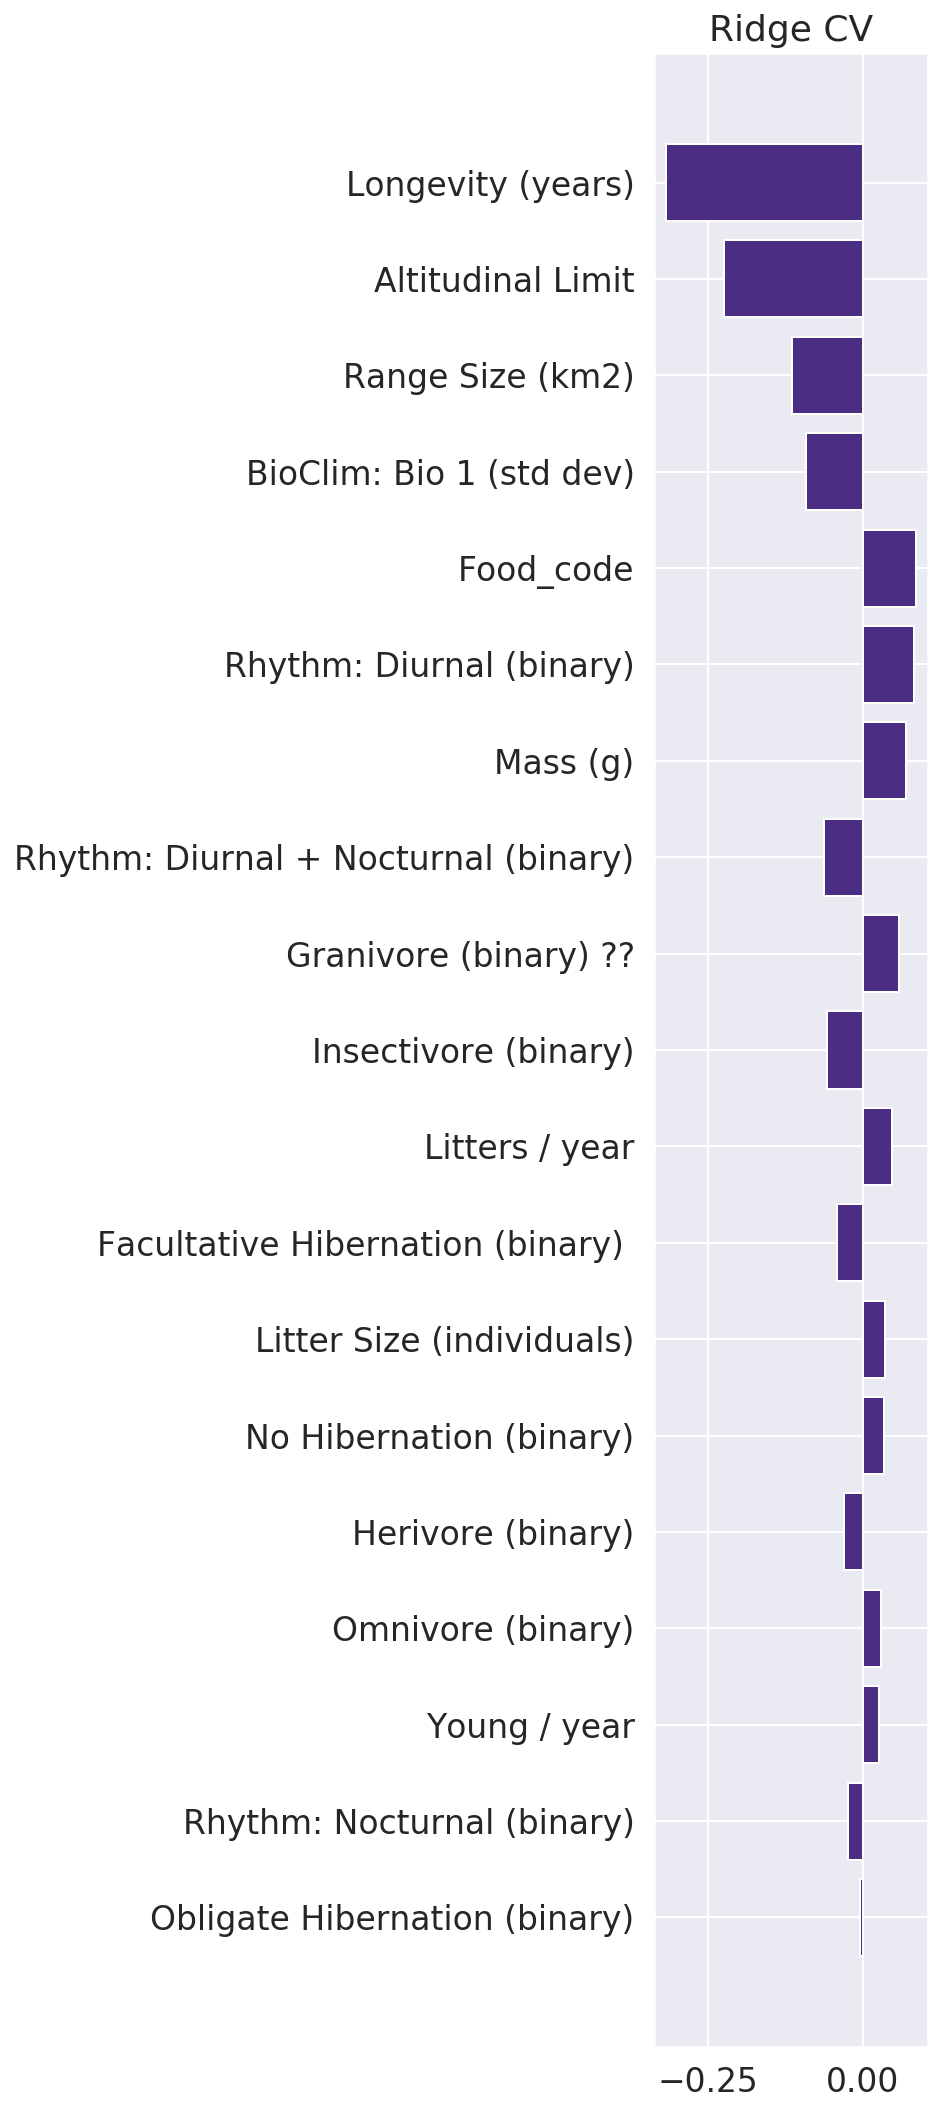

In [13]:
ridge_coefs = []
ridge_mses = []
for train, test in cv.split(td.X, td.Y):
    ridgecv = RidgeCV(normalize=False)
    ridgecv.fit(td.X[train], td.Y[train])
    preds = ridgecv.predict(td.X[test])
    error = mean_squared_error(td.Y[test], preds)
    ridge_mses.append(error)
    ridge_coefs.append(ridgecv.coef_)
    
mean_error = np.mean(ridge_mses)
std_error = np.std(ridge_mses)
mean_coefs = np.mean(ridge_coefs, axis=0)
std_coefs = np.std(ridge_coefs, axis=0)

    
plot_importance(mean_coefs, td.feature_names,  "Ridge CV",# std=std_coefs,
               save="{}_ridge-ranks.png".format(join(results_dir, dsname)))
rankings.append(['Ridge'] + list(compute_ranks(mean_coefs)))
MSEs.append(("Ridge", ridge_mses))
COEFs.append(("Ridge", mean_coefs))
COEFs_all.append(("Ridge", ridge_coefs))



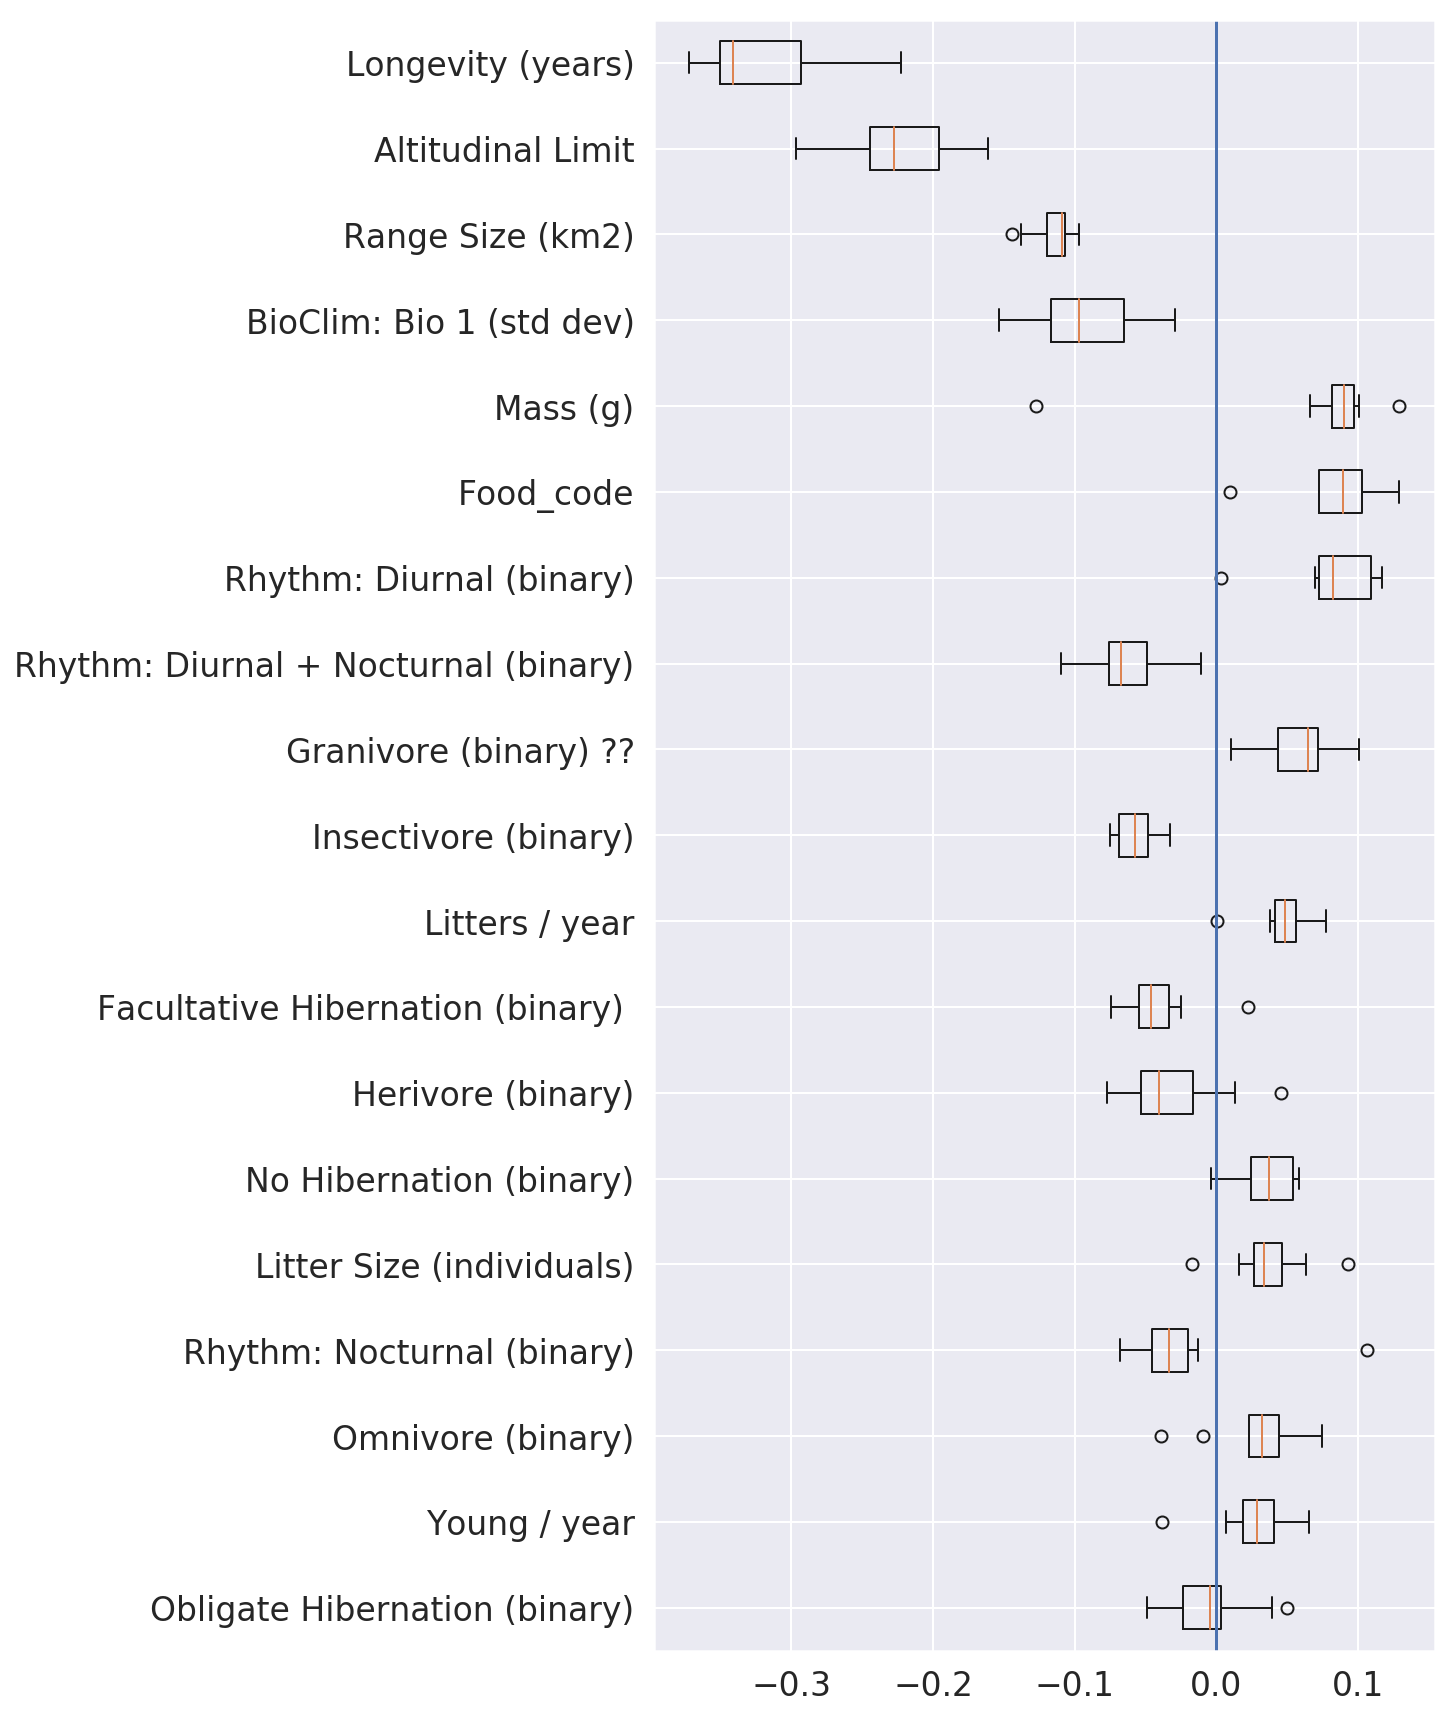

In [14]:
boxplot_importances(ridge_coefs, td.feature_names)

#### Ridge Poly

In [15]:
ridge_coefs = []
ridge_mses = []
for train, test in cv.split(X_poly_nointeract, td.Y):
    ridgecv = RidgeCV(normalize=False)
    ridgecv.fit(X_poly_nointeract[train], td.Y[train])
    preds = ridgecv.predict(X_poly_nointeract[test])
    error = mean_squared_error(td.Y[test], preds)
    ridge_mses.append(error)
    ridge_coefs.append(ridgecv.coef_)
    
mean_error = np.mean(ridge_mses)
std_error = np.std(ridge_mses)
mean_coefs = np.mean(ridge_coefs, axis=0)
std_coefs = np.std(ridge_coefs, axis=0)

    
# plot_importance(mean_coefs, td.feature_names,  "Ridge CV",# std=std_coefs,
#                save="{}_ridge-ranks.png".format(join(results_dir, dsname)))
# rankings.append(['Ridge Poly'] + list(compute_ranks(mean_coefs)))
MSEs.append(("Ridge Poly", ridge_mses))
# COEFs.append(("Ridge Poly", mean_coefs))


#### Kernel Ridge

In [16]:
kernel_ridge_coefs = []
kernel_ridge_mses = []
for train, test in cv.split(td.X, td.Y):
    print('cv split' )
    kr = KernelRidge(kernel='rbf')
    kr.fit(td.X[train], td.Y[train])
    preds = kr.predict(td.X[test])
    error = mean_squared_error(td.Y[test], preds)
    shapdata = shap.DenseData(td.X[train], td.feature_names)
    explainer = shap.KernelExplainer(kr.predict, shapdata, nsamples=100)
    kernel_ridge_coefs.append(explainer.explain(np.mat(td.X[test])).effects)
    kernel_ridge_mses.append(error)
    
#     for i in range(0, len(X_test)-1):
#         try: 
#             explanations.append(explainer.explain(np.mat(td.X[test][i:i+1, :])))
#         except Exception as e:
#             print("error on ", (i, i+1))
#             print(e)
#             continue



cv split
cv split
cv split
cv split
cv split
cv split
cv split
cv split
cv split
cv split


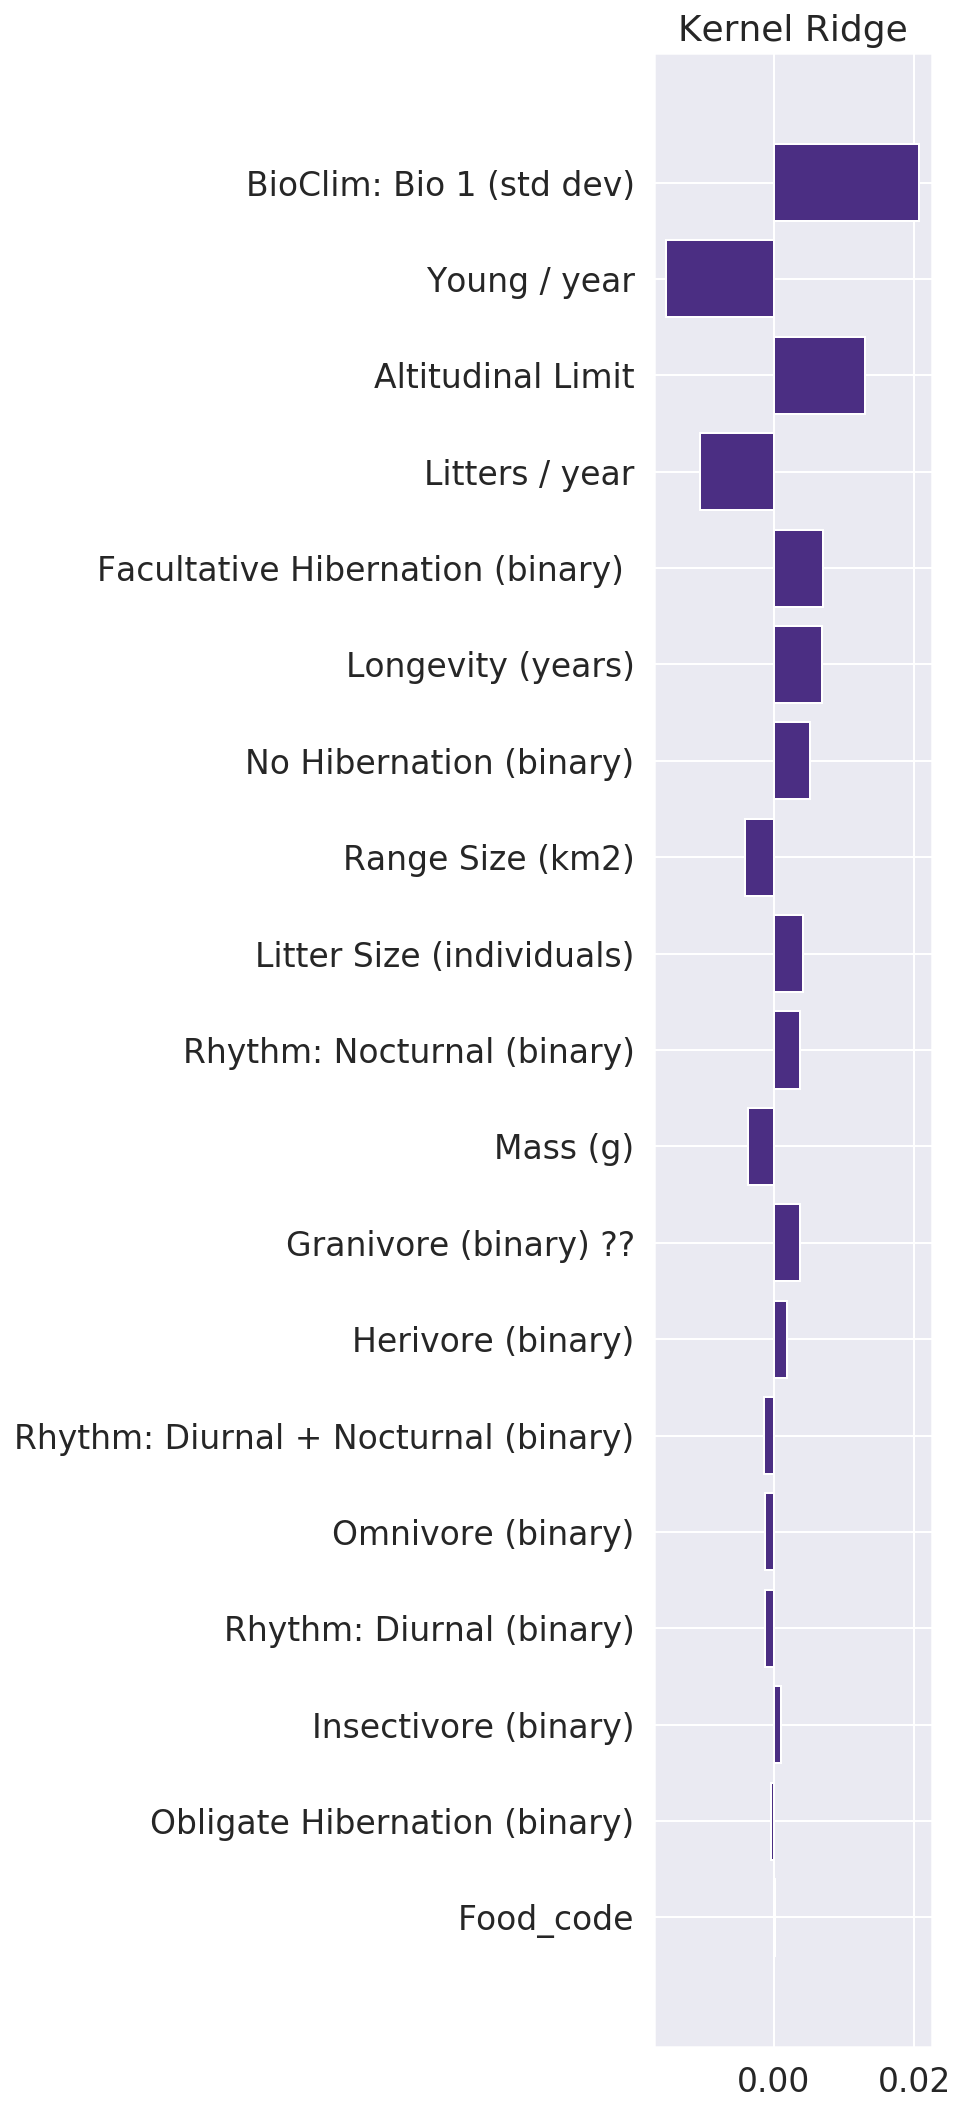

In [17]:
mean_error = np.mean(kernel_ridge_mses)
std_error = np.std(kernel_ridge_mses)
mean_coefs = np.mean(kernel_ridge_coefs, axis=0)
std_coefs = np.std(kernel_ridge_coefs, axis=0)
plot_importance(mean_coefs, td.feature_names, "Kernel Ridge", 
               save="{}_kernelridge-ranks.png".format(join(results_dir, dsname)))#, std=std_coefs)
MSEs.append(("Kernel Ridge", kernel_ridge_mses))
COEFs.append(("Kernel Ridge", mean_coefs))
COEFs_all.append(("Kernel Ridge", kernel_ridge_coefs))

rankings.append(['Kernel Ridge'] + list(compute_ranks(mean_coefs)))

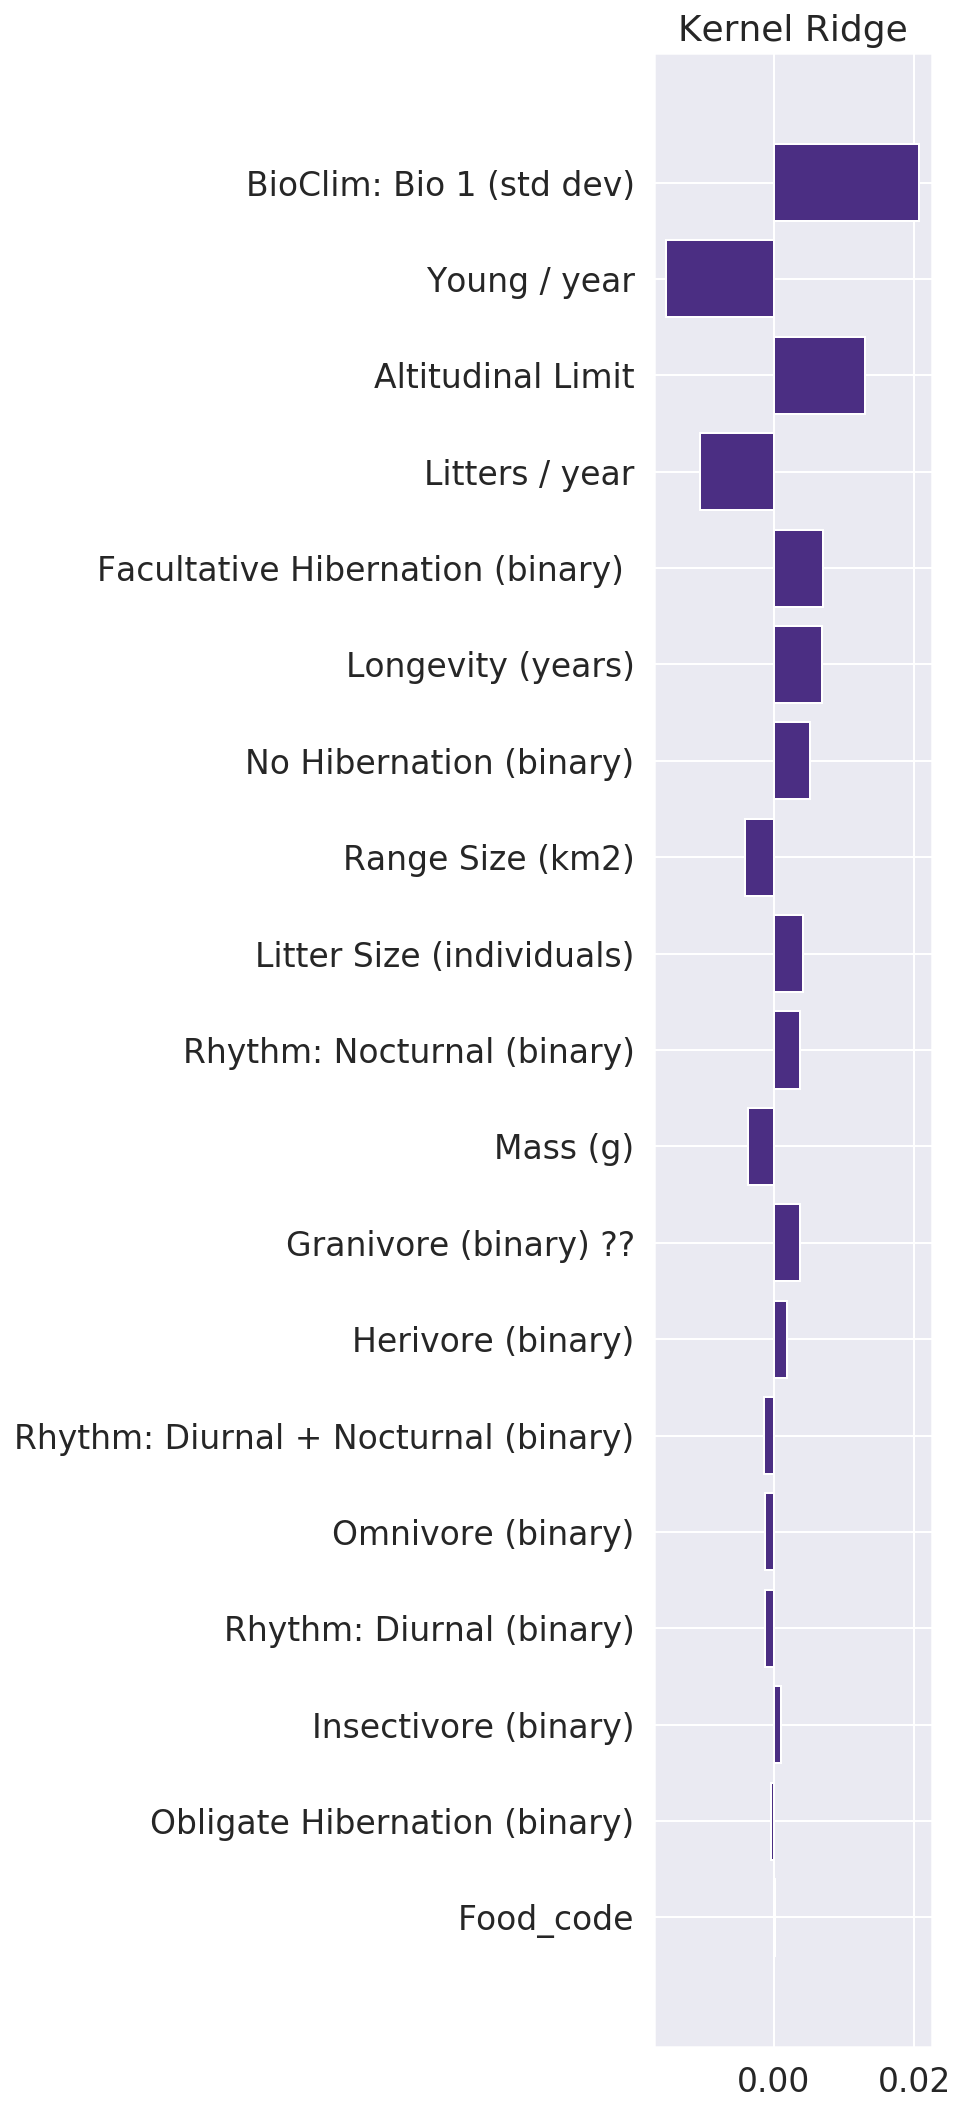

In [18]:
plot_importance(mean_coefs,
                td.feature_names,
                "Kernel Ridge", save="{}_kernelridge-nostd-ranks.png".format(join(results_dir,dsname)))
                #std=std_coefs)

rankings.append(['Kernel Ridge'] + list(compute_ranks(mean_coefs)))

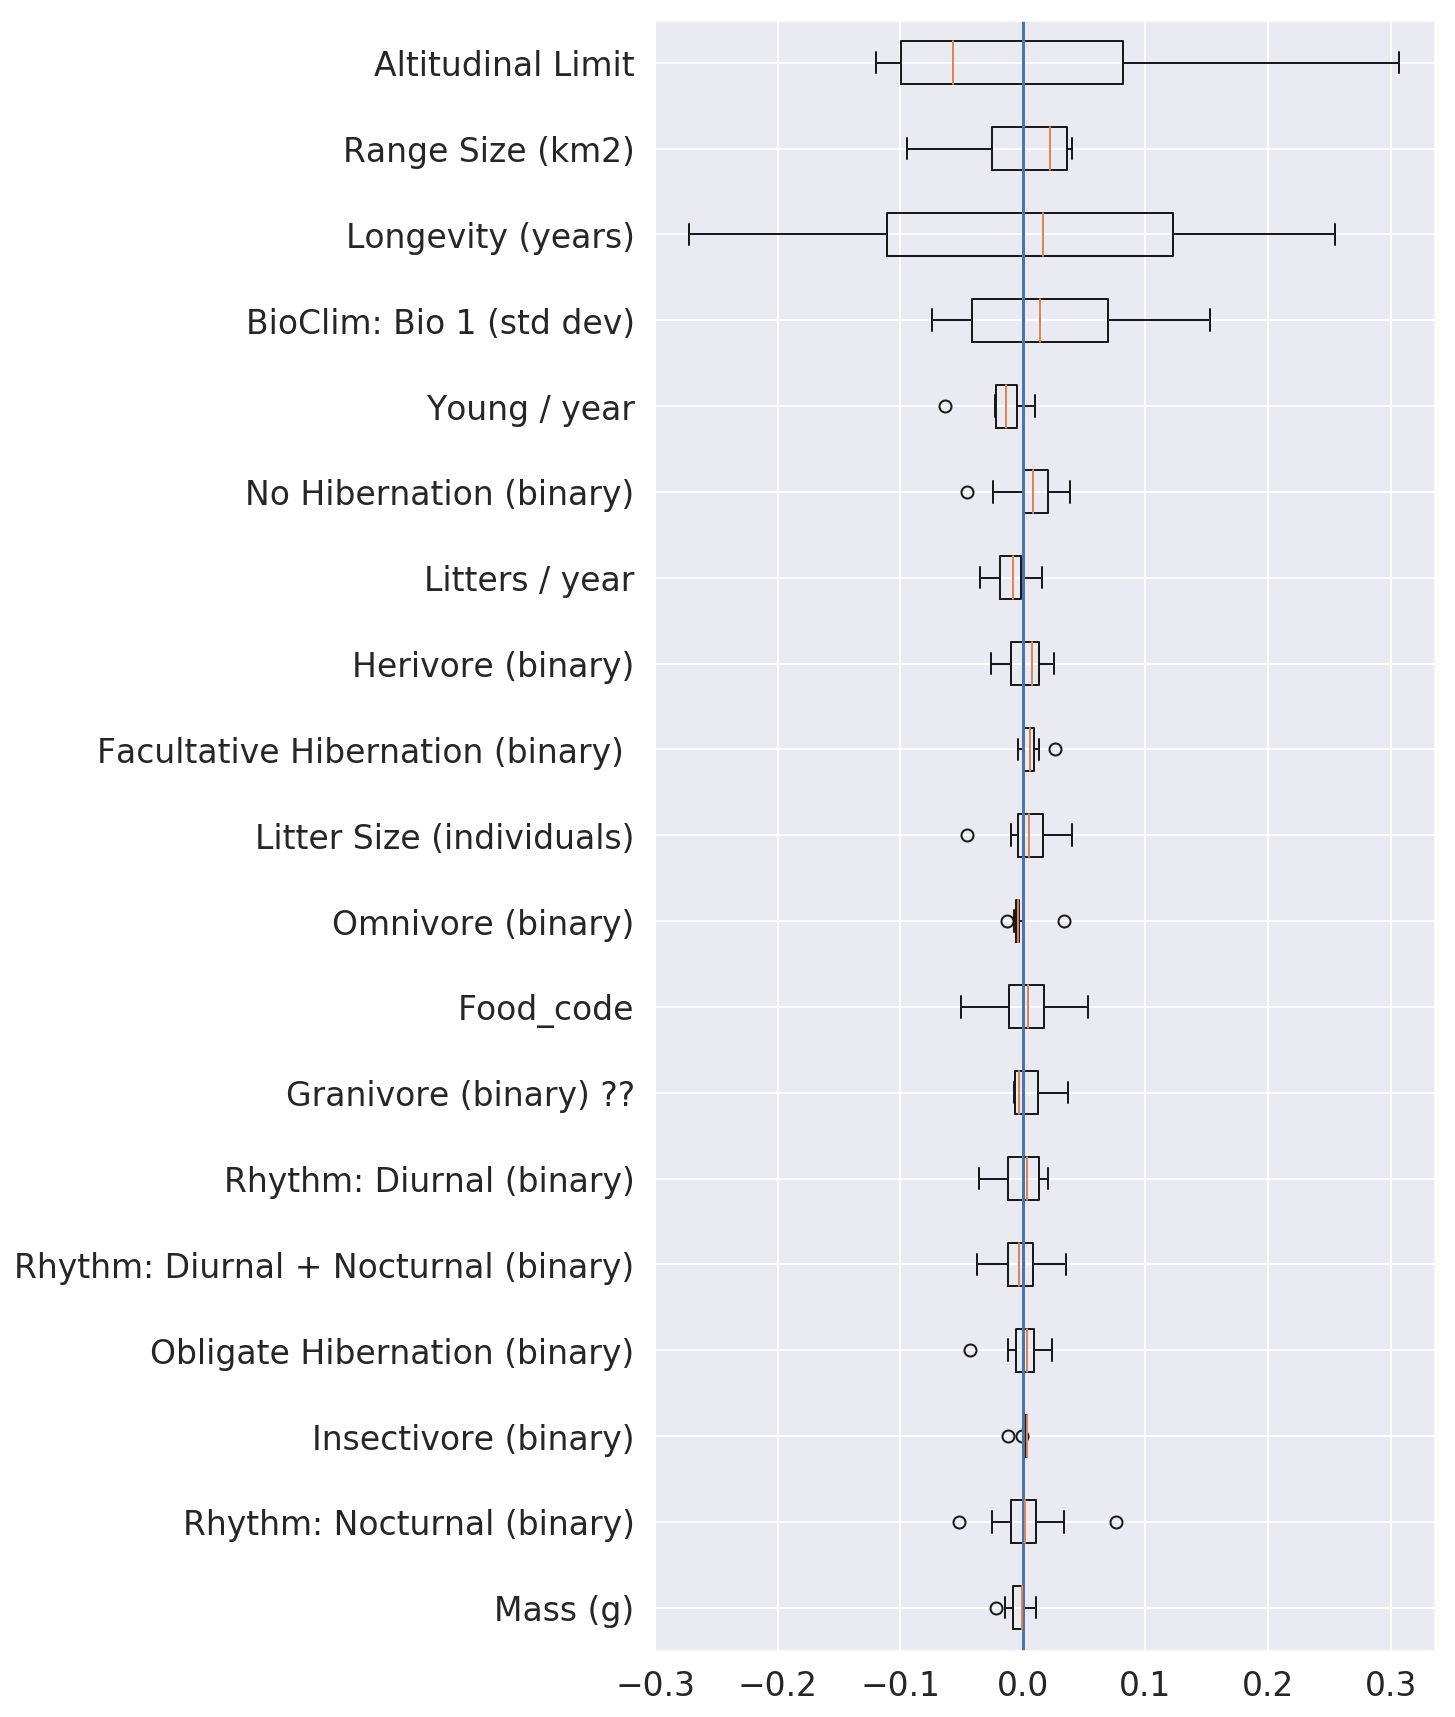

In [19]:
boxplot_importances(kernel_ridge_coefs, td.feature_names)

### Trees

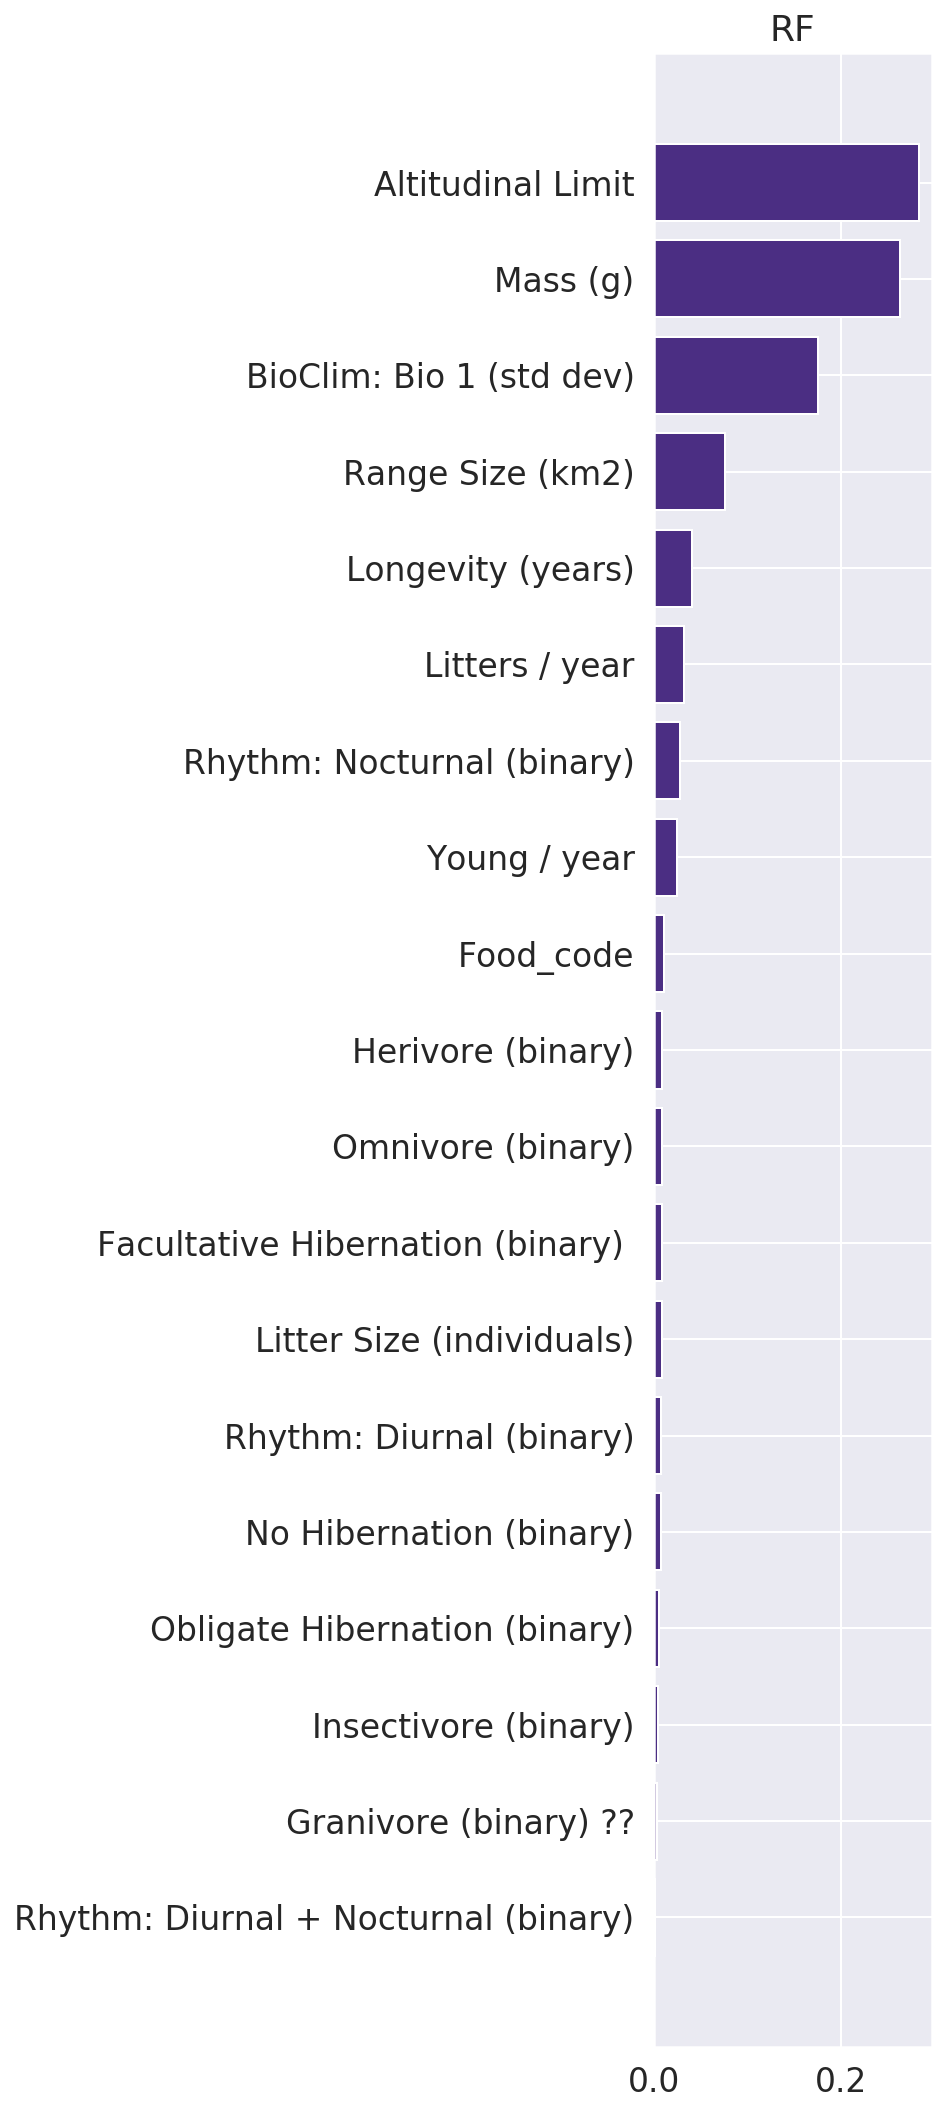

In [20]:
rf_coefs = []
rf_mses = []
for train, test in cv.split(td.X, td.Y):    
    rf = RandomForestRegressor()
    rf.fit(td.X[train], td.Y[train])
    preds = rf.predict(td.X[test])
    error = mean_squared_error(td.Y[test], preds)
    rf_mses.append(error)
    rf_coefs.append(rf.feature_importances_)

mean_error = np.mean(rf_mses)
std_error = np.std(rf_mses)
mean_coefs = np.mean(rf_coefs, axis=0)
std_coefs = np.std(rf_coefs, axis=0)
    
MSEs.append(("RF", rf_mses))
COEFs.append(("RF", mean_coefs))
COEFs_all.append(("RF", rf_coefs))

plot_importance(mean_coefs,
                td.feature_names, "RF",
                save="{}_rf-ranks.png".format(join(results_dir,dsname)))
rankings.append(['RF'] + list(compute_ranks(rf.feature_importances_)))

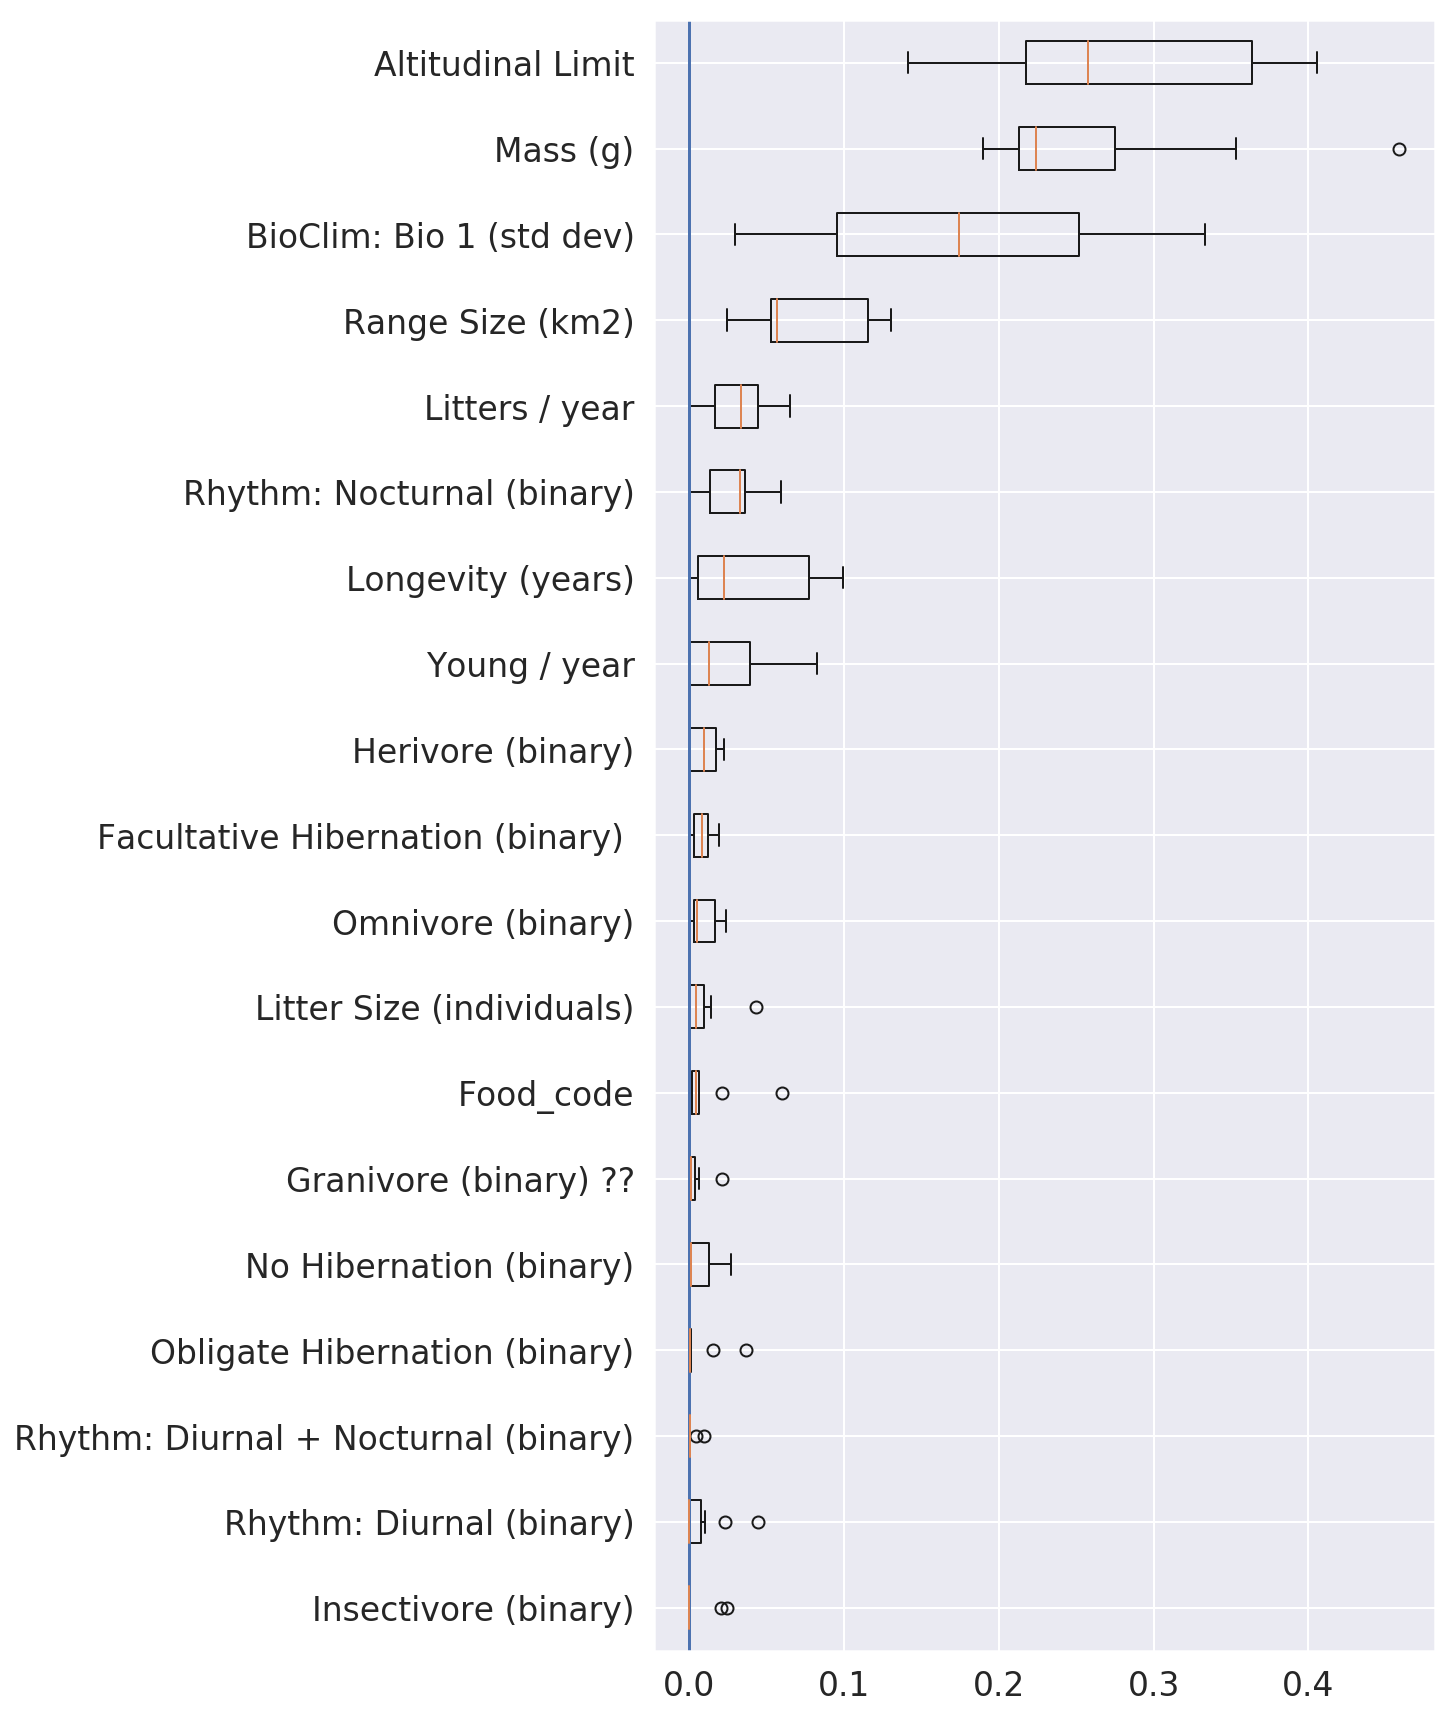

In [21]:
boxplot_importances(rf_coefs, td.feature_names)

### Support Vectors

In [22]:
baseModel = SVR()
params_grid = {
    'C'     : np.logspace(-3, 1.2),
    'gamma' : np.logspace(-3, 1.2),
    'degree': [0, 1, 2],
    'kernel': ['linear', 'poly', 'rbf']
}
gridSearch = GridSearchCV(baseModel,
                         param_grid = params_grid,
                         scoring="neg_mean_squared_error",
                         error_score = 0,
                         n_jobs = -1)

svr_coefs = []
svr_mses = []



for train, test in list(cv.split(td.X, td.Y)):   
    print("CV Run Init")
    gridSearch.fit(td.X[train], td.Y[train])
    best = gridSearch.best_estimator_
    preds = gridSearch.best_estimator_.predict(td.X[test])
    error = mean_squared_error(preds, td.Y[test])
    svr_mses.append(error)
    try:
        shapdata = shap.DenseData(td.X[train], td.feature_names) 
        explainer = shap.KernelExplainer(best.predict, shapdata, nsamples=100)
        svr_coefs.append(explainer.explain(np.mat(td.X[test])).effects)
    except Exception as e:
        print("error in SHAP, continuing")
        continue


CV Run Init
CV Run Init
CV Run Init
CV Run Init
CV Run Init
CV Run Init
CV Run Init
CV Run Init
CV Run Init
CV Run Init


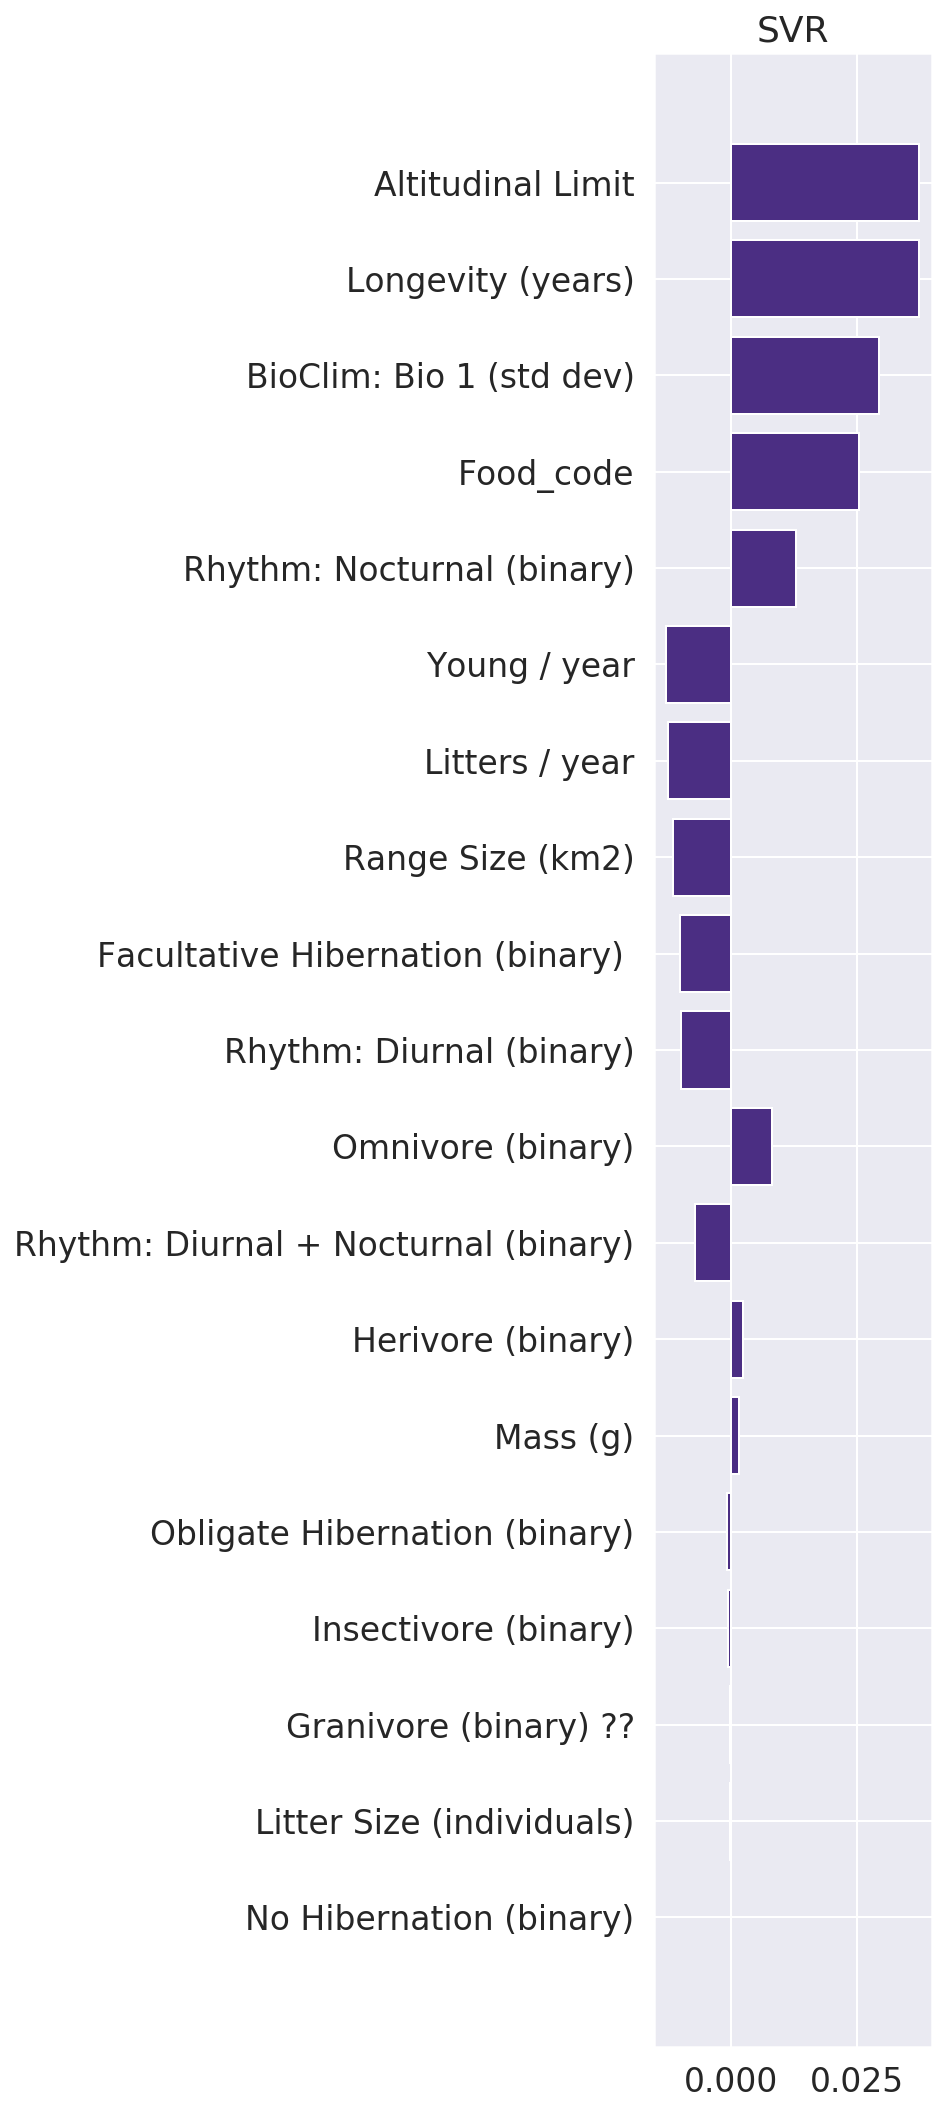

In [23]:
mean_error = np.mean(svr_mses)
std_error = np.std(svr_mses)
mean_coefs = np.mean(svr_coefs, axis=0)
std_coefs = np.std(svr_coefs, axis=0)




MSEs.append(("SVR", svr_mses))
COEFs.append(("SVR", mean_coefs))
COEFs_all.append(("SVR", svr_coefs))

plot_importance(mean_coefs,
                td.feature_names, "SVR",
                save="{}_svr-ranks.png".format(join(results_dir, dsname)))
rankings.append(['SVR'] + list(compute_ranks(mean_coefs)))

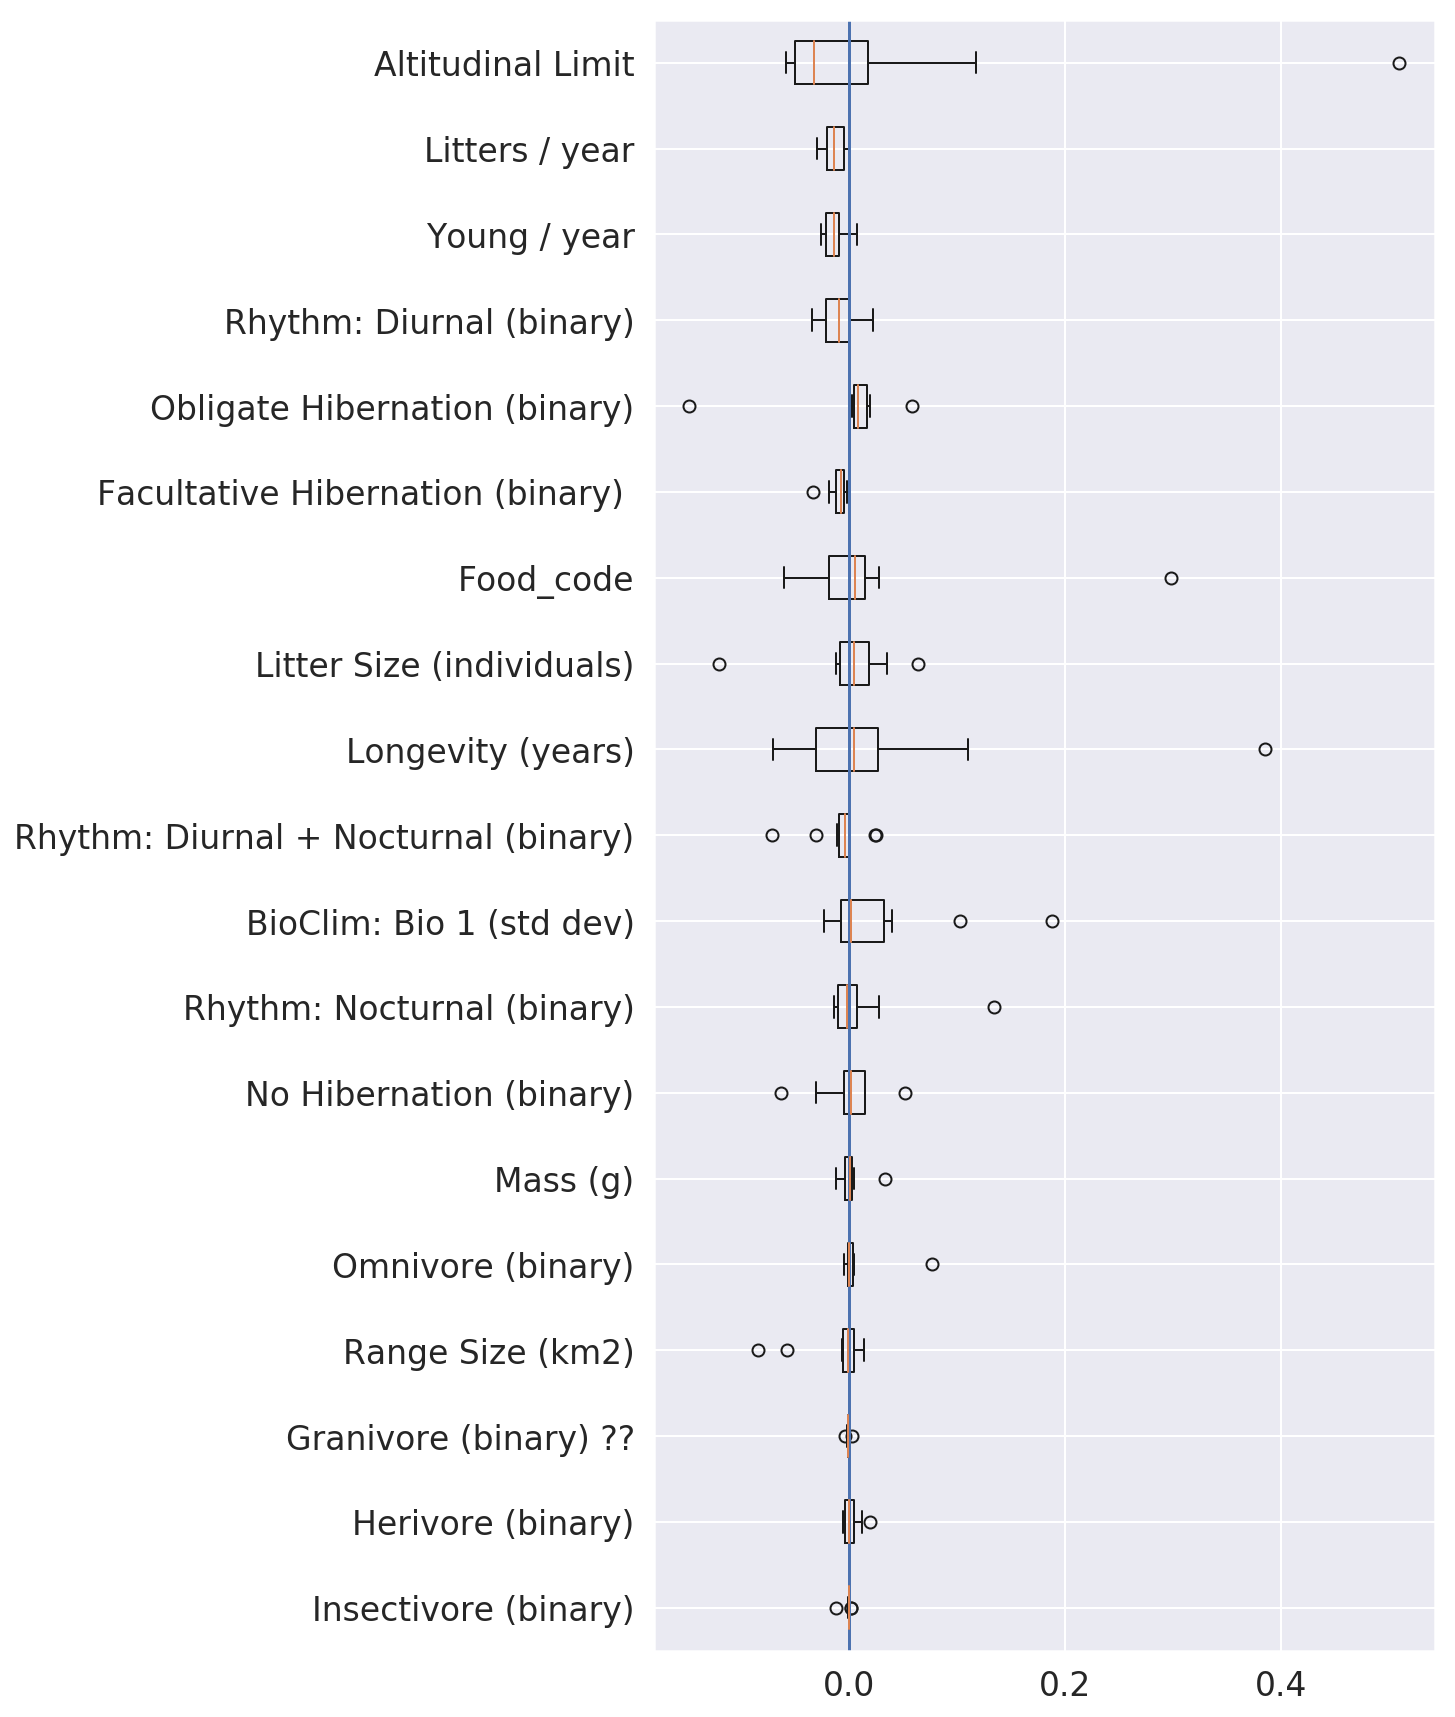

In [24]:
boxplot_importances(svr_coefs, td.feature_names)

In [25]:
results = pd.DataFrame(rankings, columns=["Method"] + td.feature_names).set_index("Method").T
results['mean'] = results.mean(axis=1)
results = results.sort_values(by=['mean'])

In [26]:
results

Method,OLS,Ridge,Kernel Ridge,Kernel Ridge,RF,SVR,mean
Altitudinal Limit,9,1,2,2,1,0,2.500000
Longevity (years),0,0,5,5,7,1,3.000000
BioClim: Bio 1 (std dev),17,3,0,0,3,2,4.166667
Litters / year,2,10,3,3,9,6,5.500000
Young / year,4,16,1,1,8,5,5.833333
Range Size (km2),13,2,7,7,2,7,6.333333
Facultative Hibernation (binary),3,11,4,4,10,8,6.666667
Mass (g),12,6,10,10,0,13,8.500000
Rhythm: Nocturnal (binary),11,17,9,9,4,4,9.000000
Rhythm: Diurnal (binary),5,5,15,15,16,9,10.833333


In [27]:
results.to_csv("{}-rank.csv".format(dsname))
from pandas.tools.plotting import table


/home/ec2-user/miniconda3/envs/traits-env/lib/python3.5/site-packages/ipykernel_launcher.py:6: FutureWarning: 'pandas.tools.plotting.table' is deprecated, import 'pandas.plotting.table' instead.
  


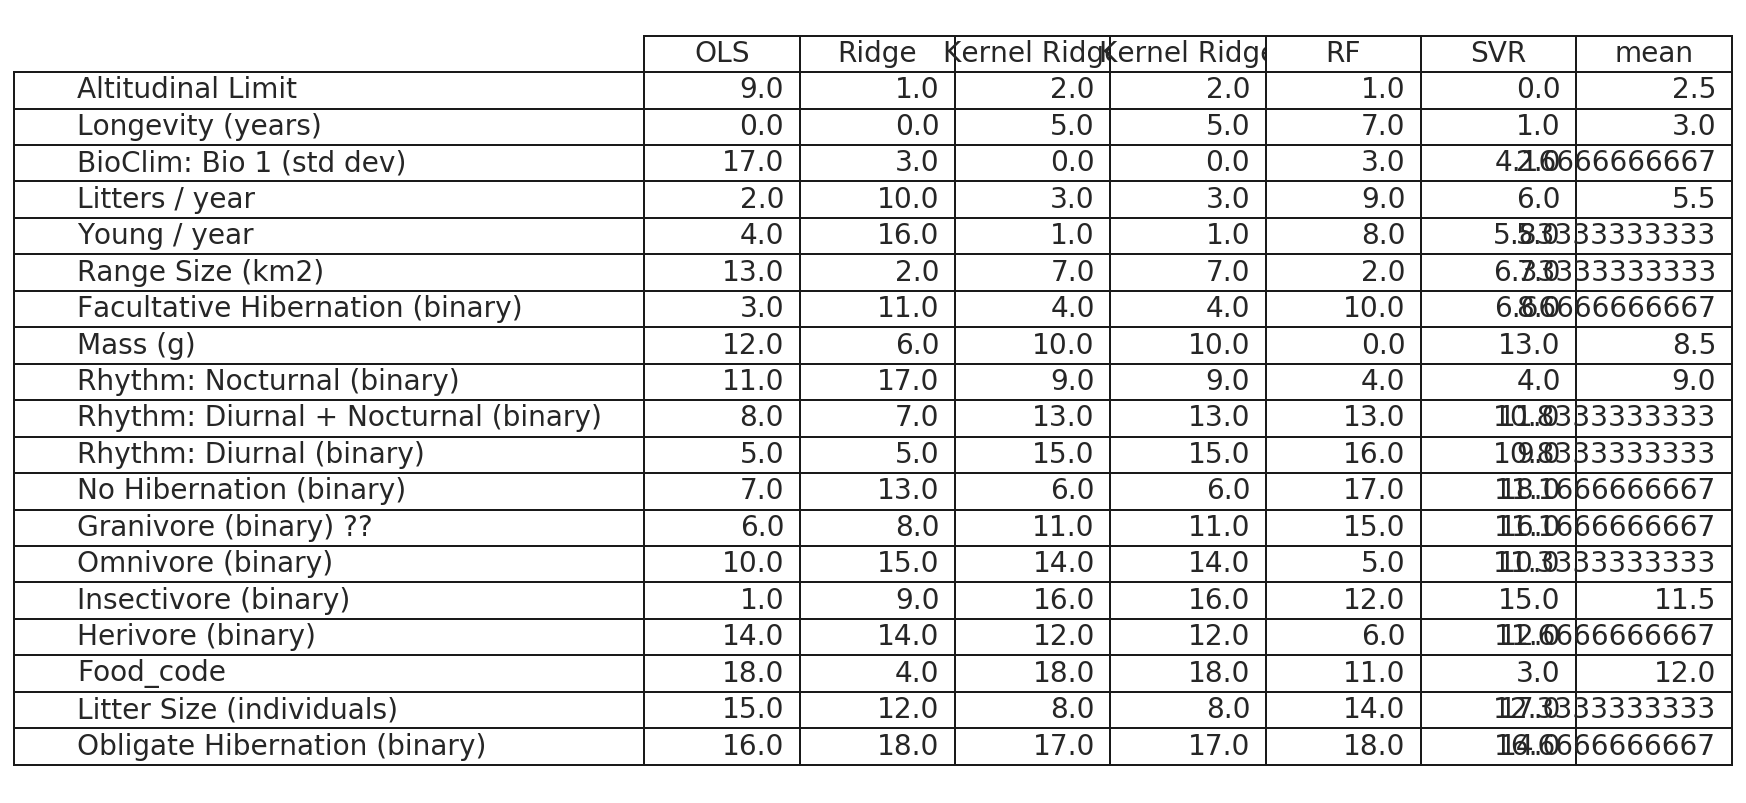

In [28]:
results = results.sort_values(by='mean')
fig = plt.figure(figsize=(7, 6))
ax = plt.subplot(111, frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis
tab = table(ax, results, loc='upper left')
tab.auto_set_font_size(False)
tab.set_fontsize(14)
tab.scale(1.2, 1.3)
fig.tight_layout()

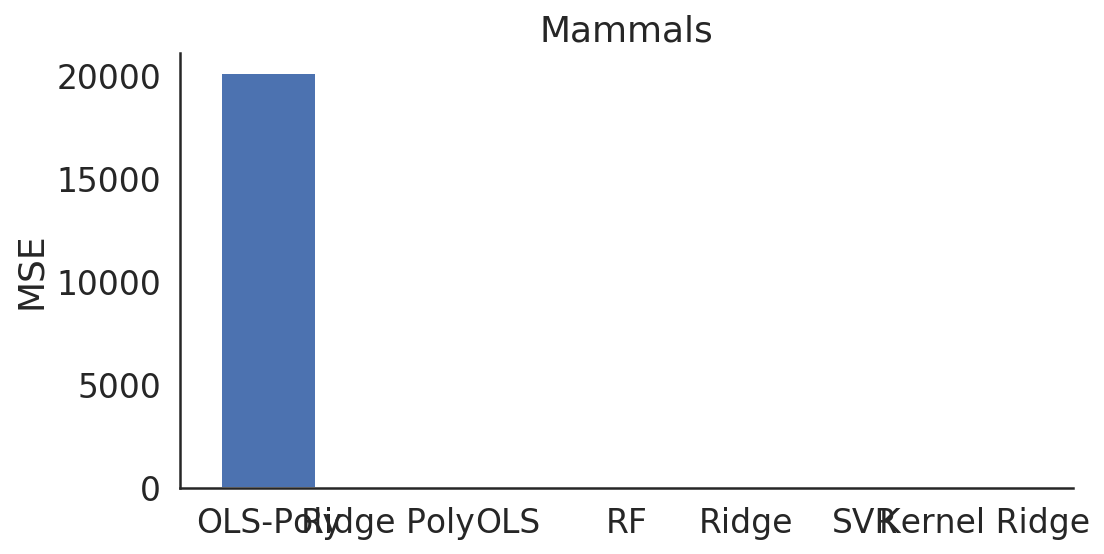

In [29]:
sns.set(style="white", font_scale=1.5)
fig = plt.figure(figsize=(8, 4))
labels, errors = zip(*MSEs)
errors = np.array(errors)
error_means = np.mean(errors, axis=1)
error_stds = np.std(errors, axis=1)
labels = np.array(labels)
sorted_idx = np.argsort(error_means)[::-1]
plt.bar(range(0, len(MSEs)), error_means[sorted_idx])#, yerr=error_stds)
plt.xticks(range(0, len(MSEs)), labels[sorted_idx])
plt.ylabel("MSE")
plt.title(dataset['name'])
sns.despine()
plt.savefig("{}-msecompare.png".format(join(results_dir, dsname)), dpi=200)


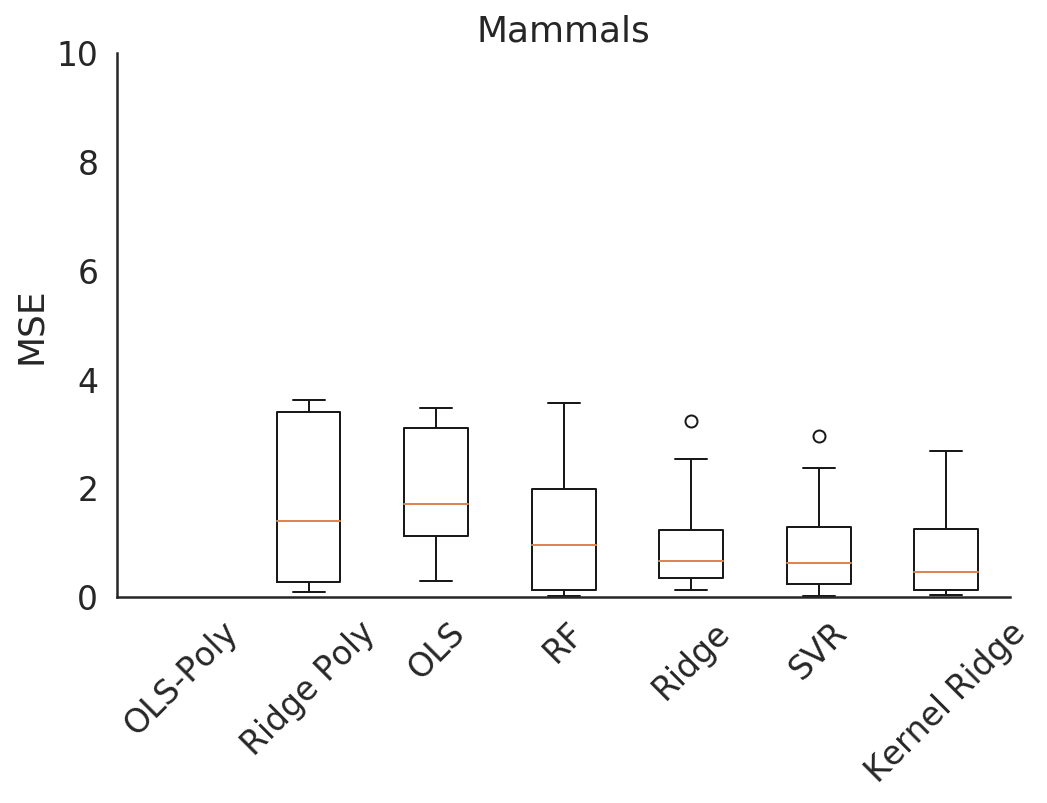

In [30]:
sns.set(style='white', font_scale=1.5)
plt.figure(figsize=(8,5))
plt.boxplot(errors[sorted_idx].T)
plt.xticks(range(1, len(MSEs) +1), labels[sorted_idx], rotation = 45)
plt.ylim(0, 10)
plt.ylabel("MSE")
plt.title(dataset['name'])
sns.despine()
plt.savefig("{}-msecompare-boxplot.png".format(join(results_dir, dsname)), dpi=200)



In [31]:
[(m[0], len(m[1])) for m in COEFs]

[('OLS', 19), ('Ridge', 19), ('Kernel Ridge', 19), ('RF', 19), ('SVR', 19)]

### Save Mean Coefficients 

In [32]:
coefs_df = pd.DataFrame(dict(COEFs))
coefs_df['trait'] = td.feature_names
cols = coefs_df.columns.tolist()
cols = cols[-1:] + cols[:-1]
coefs_df = coefs_df[cols]
# sort by mean rank
coefs_df = coefs_df.set_index('trait').loc[results.index].reset_index()
coefs_df.to_csv("{}-coefs.csv".format(join(results_dir, dsname)), index=False)

In [33]:
coefs_df

,index,Kernel Ridge,OLS,RF,Ridge,SVR
0,Altitudinal Limit,0.013003,-0.350963,0.282716,-0.223200,0.037265
1,Longevity (years),0.006806,-1.478560,0.040845,-0.316766,0.037231
2,BioClim: Bio 1 (std dev),0.020692,0.041734,0.175057,-0.091361,0.029341
3,Litters / year,-0.010574,-1.077397,0.032367,0.047841,-0.012348
4,Young / year,-0.015312,0.650077,0.024566,0.026380,-0.012760
5,Range Size (km2),-0.004171,-0.123145,0.076263,-0.114431,-0.011531
6,Facultative Hibernation (binary),0.006928,-0.701064,0.008790,-0.041540,-0.009979
7,Mass (g),-0.003749,0.144936,0.262519,0.070782,0.001686
8,Rhythm: Nocturnal (binary),0.003772,-0.253017,0.027951,-0.023588,0.012963
9,Rhythm: Diurnal + Nocturnal (binary),-0.001440,-0.403197,0.001671,-0.061993,-0.007050


### Save All Coefficients

In [34]:
modelTypes, all_coefs = zip(*COEFs_all)
rows = []
for mt in modelTypes:
    rows.append(pd.DataFrame())
np.save("{}-all_coefs.npy".format(join(results_dir, dsname)), np.array(all_coefs))

In [35]:
coefs_by_trait = np.moveaxis(all_coefs, 2, 0)
dfs = []
for data in coefs_by_trait:
    dfs.append(pd.concat([pd.DataFrame({m : [data[i, :]]}) for i, m in enumerate(modelTypes)], axis=1))
    
merged = pd.concat(dfs)
merged.index = td.feature_names
merged.loc[results.index]
merged.to_csv("{}-all_coefs.csv".format(join(results_dir, dsname)))
dump(merged, open("{}-all_coefs.pkl".format(join(results_dir, dsname)), 'wb'))

### Save MSEs 


In [36]:
pd.DataFrame(MSEs, columns=["method", "MSEs"]).to_csv("{}-mseraw.csv".format(join(results_dir, dsname)))

### Save Trait Ordering

In [37]:
pd.Series(td.feature_names).to_csv("{}-traitnames.csv".format(join(results_dir, dsname)), index=False)

In [38]:
np.save("{}-mean-rank-trait-order.npy".format(join
                                              (results_dir, dsname)),
        np.array([list(results.index).index(f) for f in td.feature_names]))

In [39]:
modelTypes

('OLS', 'Ridge', 'Kernel Ridge', 'RF', 'SVR')